In [1]:
#| code-summary: Load Packages
#| code-fold: true

# numerical calculation & data frames
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import sbcustom as sbc

# statistics
import statsmodels.api as sm

In [2]:
#| echo: false
from IPython.display import display
pd.options.display.notebook_repr_html = False

In [3]:
#| code-summary: Options
#| code-fold: true

# pandas options
pd.set_option("mode.copy_on_write", True)
pd.options.display.precision = 2
pd.options.display.float_format = '{:.2f}'.format  # pd.reset_option('display.float_format')
pd.options.display.max_rows = 7

# Numpy options
np.set_printoptions(precision = 2, suppress=True)

# Why are low quality diamonds more expensive?

In [4]:
diamonds = sm.datasets.get_rdataset("diamonds", "ggplot2").data

# cut, color, clarity 모두 categorical type으로 변형
diamonds["cut"] = pd.Categorical(
    diamonds["cut"], 
    categories=["Fair", "Good", "Very Good", "Premium", "Ideal"],
    ordered=True
)
diamonds["color"] = pd.Categorical(
    diamonds["color"], 
    categories=["D", "E", "F", "G", "H", "I", "J"],
    ordered=True
)
diamonds["clarity"] = pd.Categorical(
    diamonds["clarity"], 
    categories=["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"],
    ordered=True
)

In [420]:
cut = sbc.rangeplot(diamonds, x="cut", y="price")
color = sbc.rangeplot(diamonds, x="color", y="price")
clarity = sbc.rangeplot(diamonds, x="clarity", y="price")

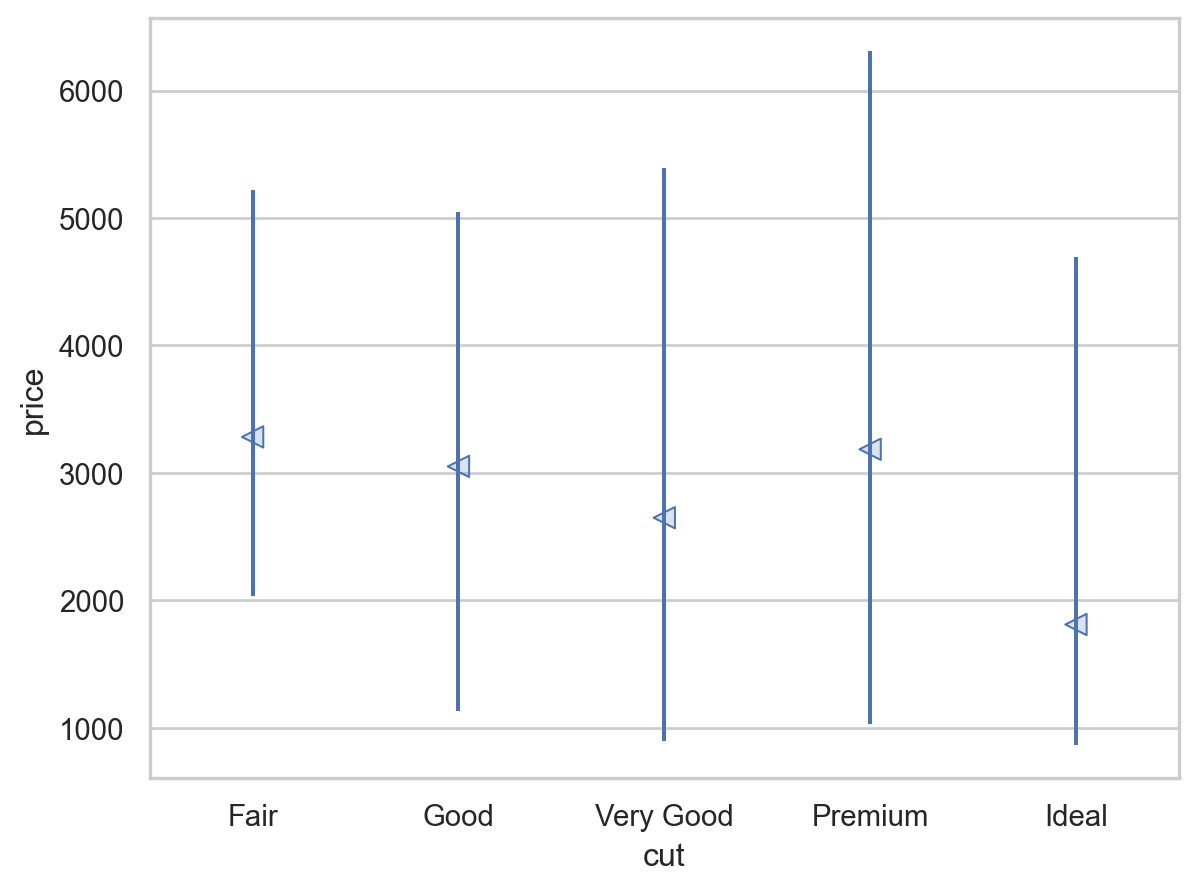

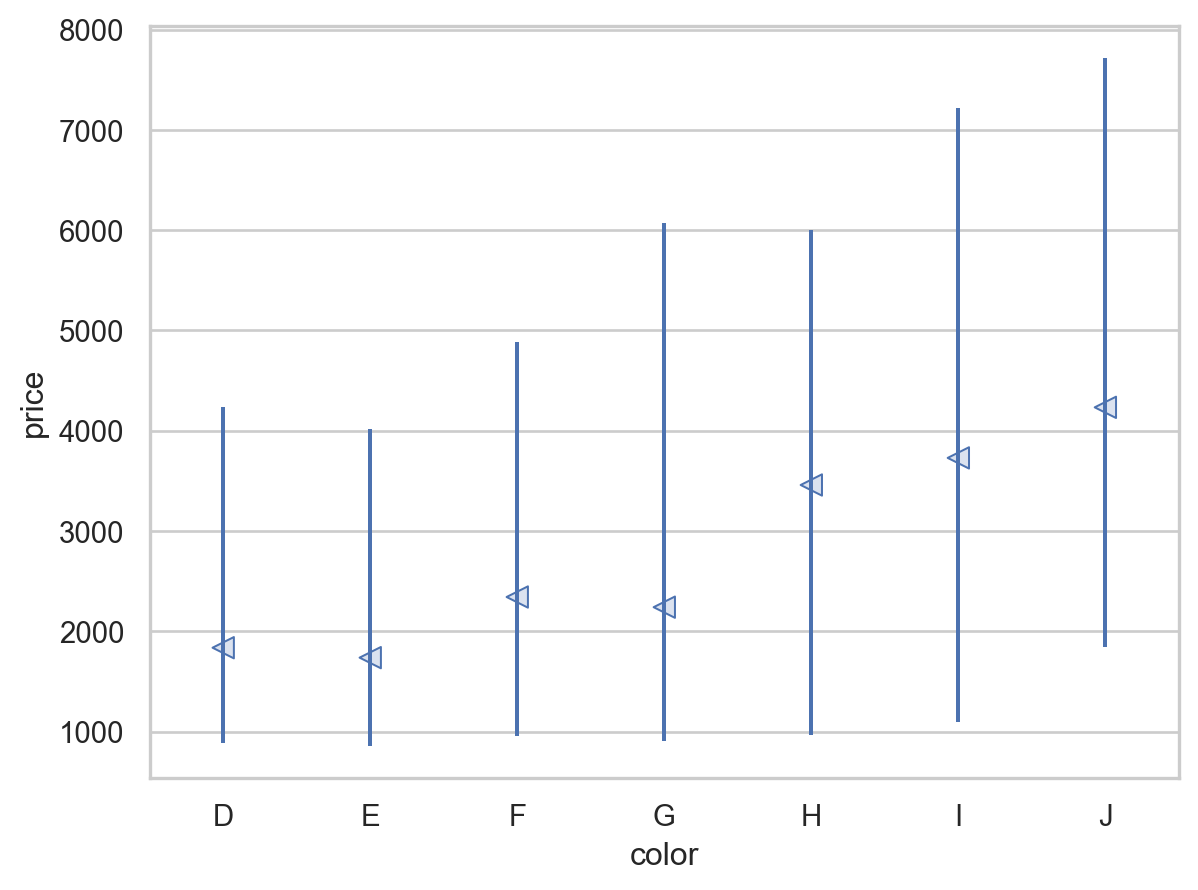

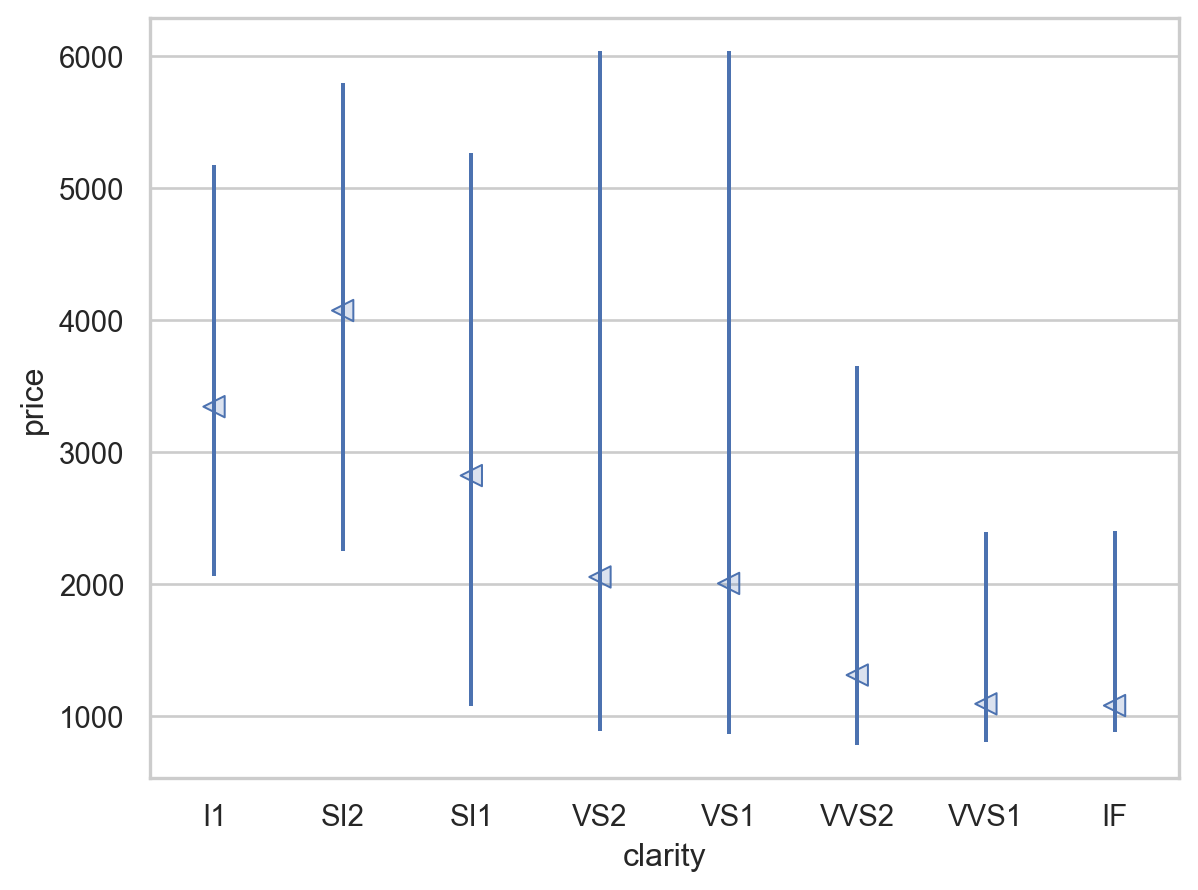

In [421]:
#| layout-ncol: 2
#| echo: false
display(cut)
display(color)
display(clarity)

## Price and carat

다이아몬드의 퀄리티(cut, color, clarity)가 좋을수록 가벼워짐

In [422]:
price = (
    so.Plot(diamonds, x='carat', y='price')
    .add(so.Dots(alpha=.1))
)
cut = sbc.rangeplot(diamonds, x="cut", y="carat")
color = sbc.rangeplot(diamonds, x="color", y="carat")
clarity = sbc.rangeplot(diamonds, x="clarity", y="carat")

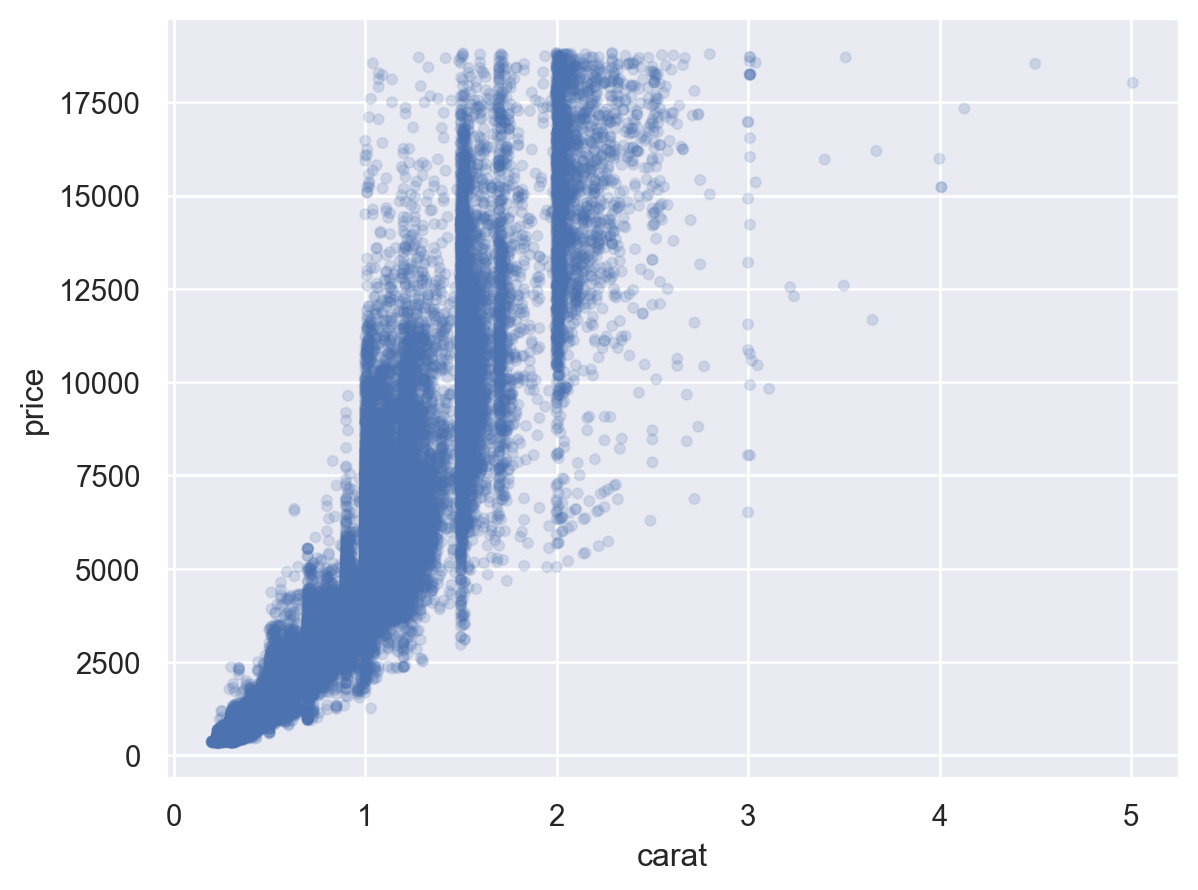

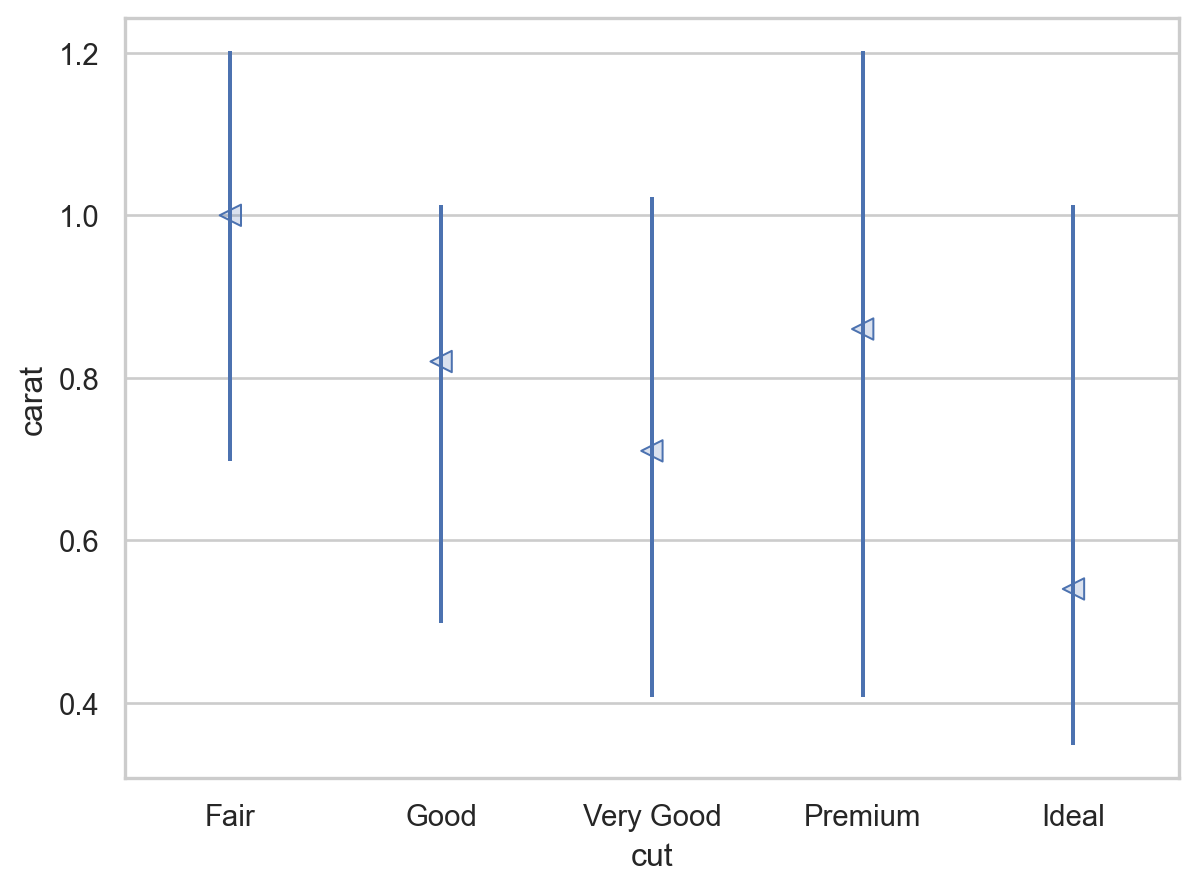

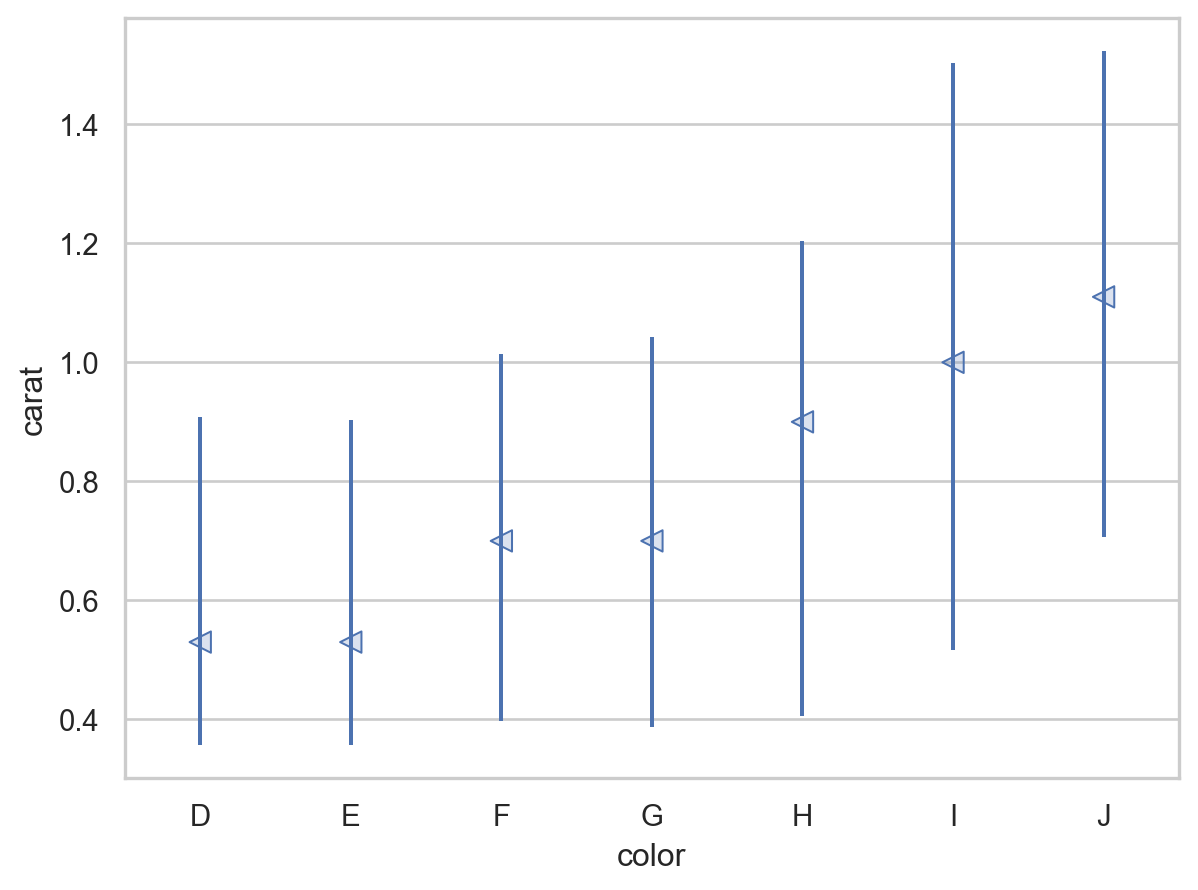

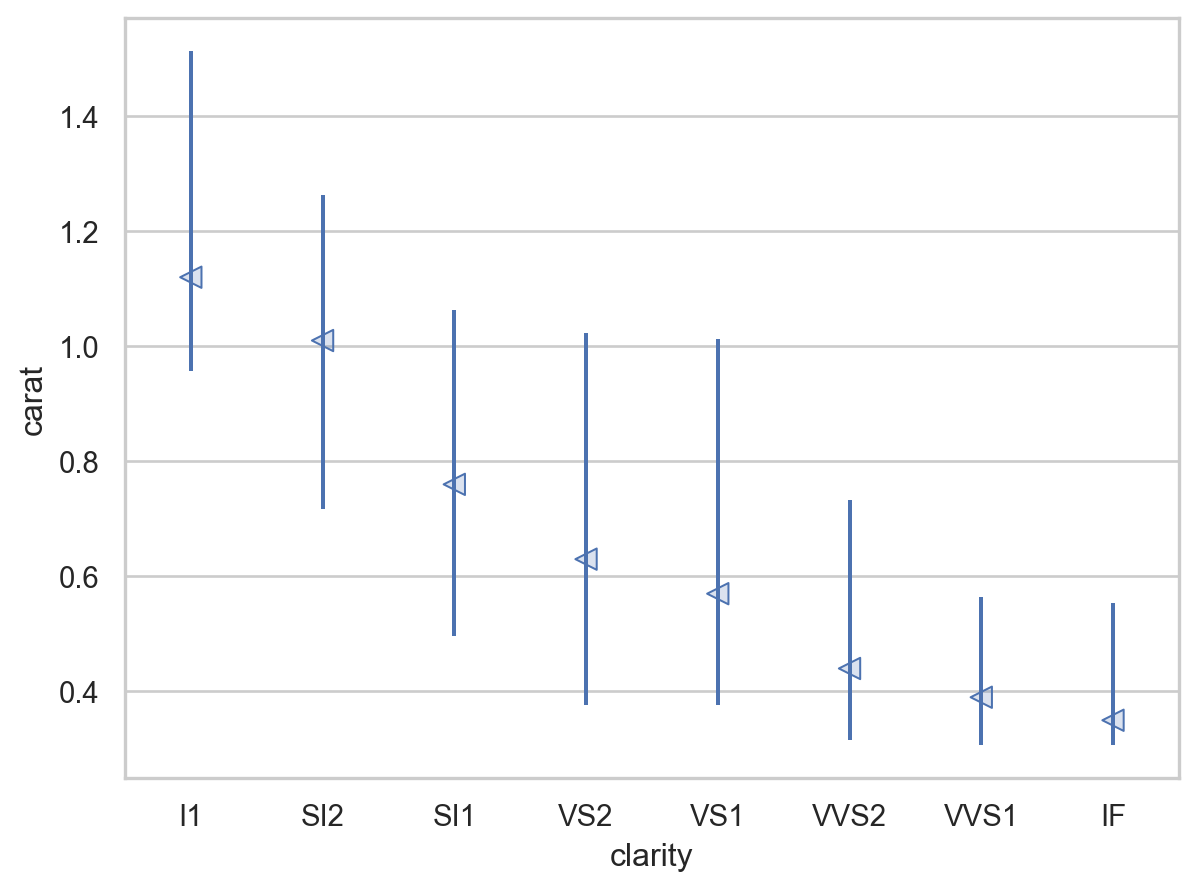

In [423]:
#| layout-ncol: 2
#| echo: false
display(price)
display(cut)
display(color)
display(clarity)

![](images/causal_diagram.png){width=600}

<br>
다이아몬드의 퀄리티가 가격에 주는 영향/예측을 정확히 파악하기 위해 다음과 같은 절차를 통해 가격 대신 “캐럿으로 설명되지 않는 가격”(residuals)으로 종속변수를 대체함

1. 우선, 2.5캐럿 이하로 제한하고,
2. 가격과 캐럿을 log-transform하여 선형모형을 세움
3. 이 모형으로 잔차를 구하고,
4. 다이아몬드의 퀄리티와 이 잔차와의 관계를 살펴봄

In [424]:
diamonds2 = diamonds.query("carat < 2.5").assign(
    lprice=lambda x: np.log2(x.price), 
    lcarat=lambda x: np.log2(x.carat)
)

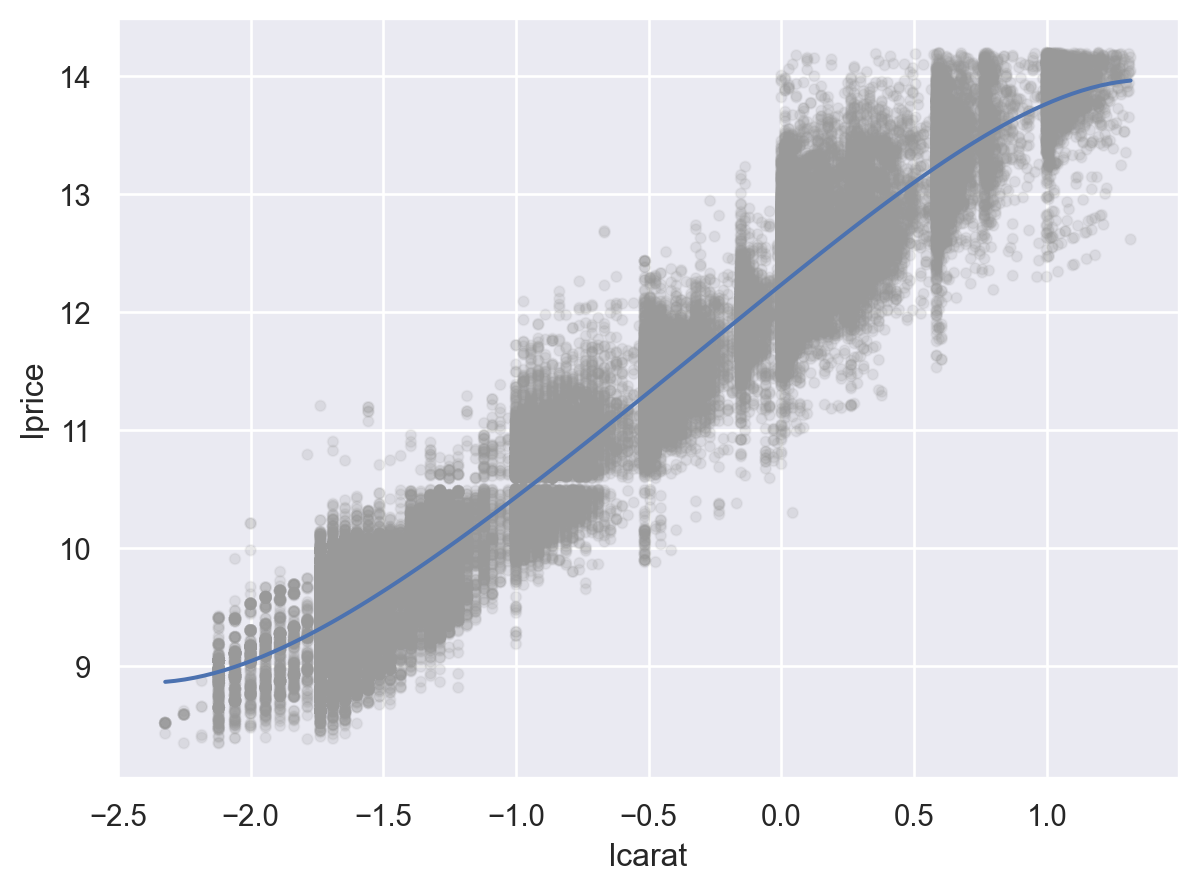

In [425]:
(
    so.Plot(diamonds2, x='lcarat', y='lprice')
    .add(so.Dots(color=".6", alpha=.1))
    .add(so.Line(), so.PolyFit(5))
)

In [426]:
# 캐럿으로 가격을 예측하는 선형모형
from statsmodels.formula.api import ols
mod_diamonds = ols("lprice ~ lcarat", data=diamonds2).fit()

In [427]:
mod_diamonds.params

Intercept   12.19
lcarat       1.68
dtype: float64

Model: $\displaystyle lprice = 12.19\cdot lcarat + 1.68 + e$

In [428]:
# data range from the carat variable
grid = pd.DataFrame({"carat": []})
grid["carat"]= np.linspace(diamonds2.carat.min(), diamonds2.carat.max(), 20)
grid = grid.assign(
    lcarat=lambda x: np.log2(x.carat),
    lprice=lambda x: mod_diamonds.predict(x.lcarat),
    price=lambda x: 2**x.lprice
)

In [429]:
grid

    carat  lcarat  lprice    price
0    0.20   -2.32    8.29   312.79
1    0.32   -1.64    9.43   691.47
2    0.44   -1.18   10.21  1182.86
..    ...     ...     ...      ...
17   2.25    1.17   14.16 18318.33
18   2.37    1.24   14.29 19999.52
19   2.49    1.32   14.41 21740.08

[20 rows x 4 columns]

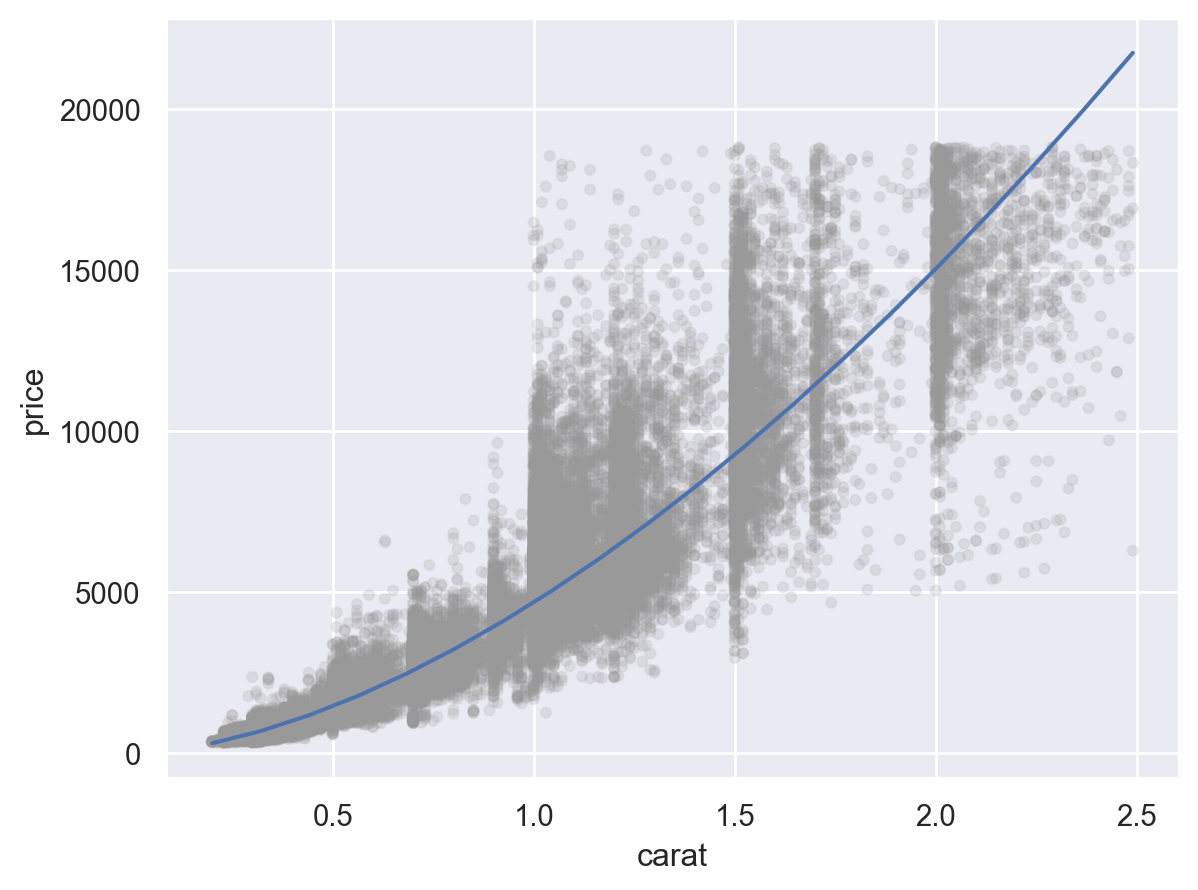

In [430]:
(
    so.Plot(diamonds2, x='carat', y='price')
    .add(so.Dots(color=".6", alpha=.1))
    .add(so.Line(), x=grid.carat, y=grid.price)
)

- 캐럿과 가격은 비선형적인 관계에 있으며, 이를 log-transform하여 선형적인 관계로 만들어줌
- 또한, variation은 캐럿이 증가함에 따라 비례해서 커지는 양상을 보임; 이 또한 log-transform을 통해 해결되었음

Residual plot: 위 모형은 충분히 좋은가?

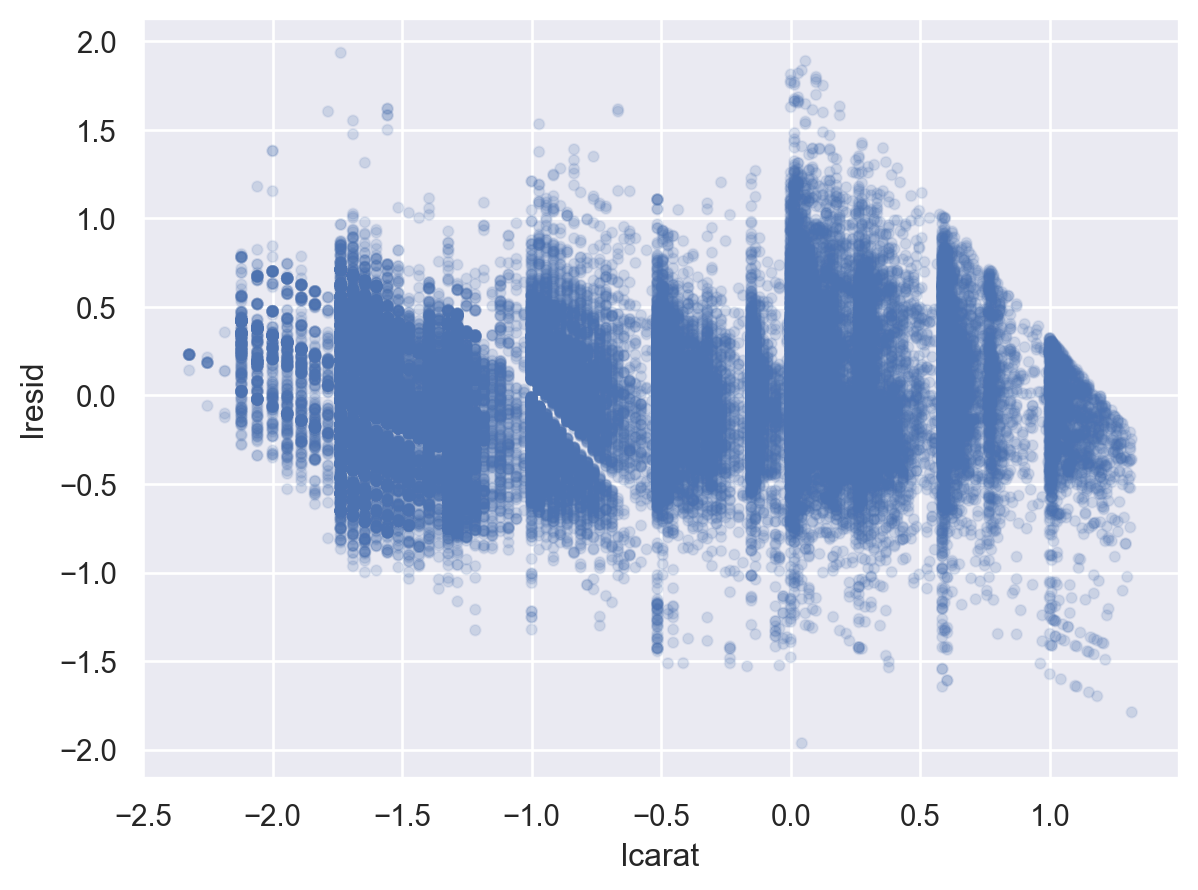

In [431]:
diamonds2["lresid"] = mod_diamonds.resid

(
    so.Plot(diamonds2, x='lcarat', y='lresid')
    .add(so.Dots(alpha=.1))
)

이제, 다이아몬드의 퀄리티와 위에서 구한 가격의 residuals과의 관계를 살펴보면,

- y축은 log2 scale로 변환된 것이므로, 원래 단위로 이해하면,
    - residual +1은 캐럿으로 예측되는 가격(residual = 0)보다 가격이 2배 비싸다는 것을 의미
    - residual -1은 캐럿으로 예측되는 가격(residual = 0)보다 가격이 1/2배 낮다는 것을 의미
  
- 이는 **캐럿의 영향을 고려한 후에**, 다이아몬드의 퀄리티 각각이 가격에 (상대적으로) 얼마나 영향을 주는지를 가늠할 수 있음

In [432]:
cut = sbc.rangeplot(diamonds2, x="cut", y="lresid")
color = sbc.rangeplot(diamonds2, x="color", y="lresid")
clarity = sbc.rangeplot(diamonds2, x="clarity", y="lresid")

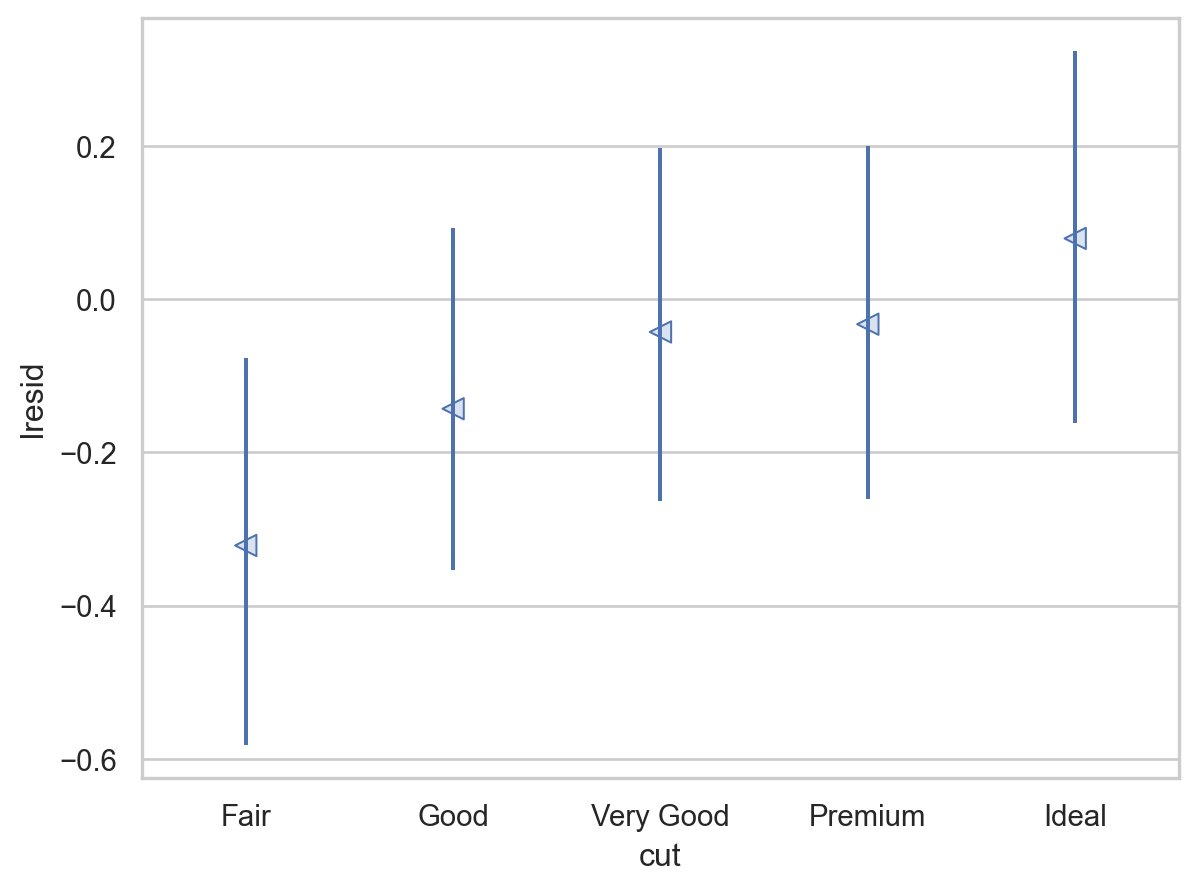

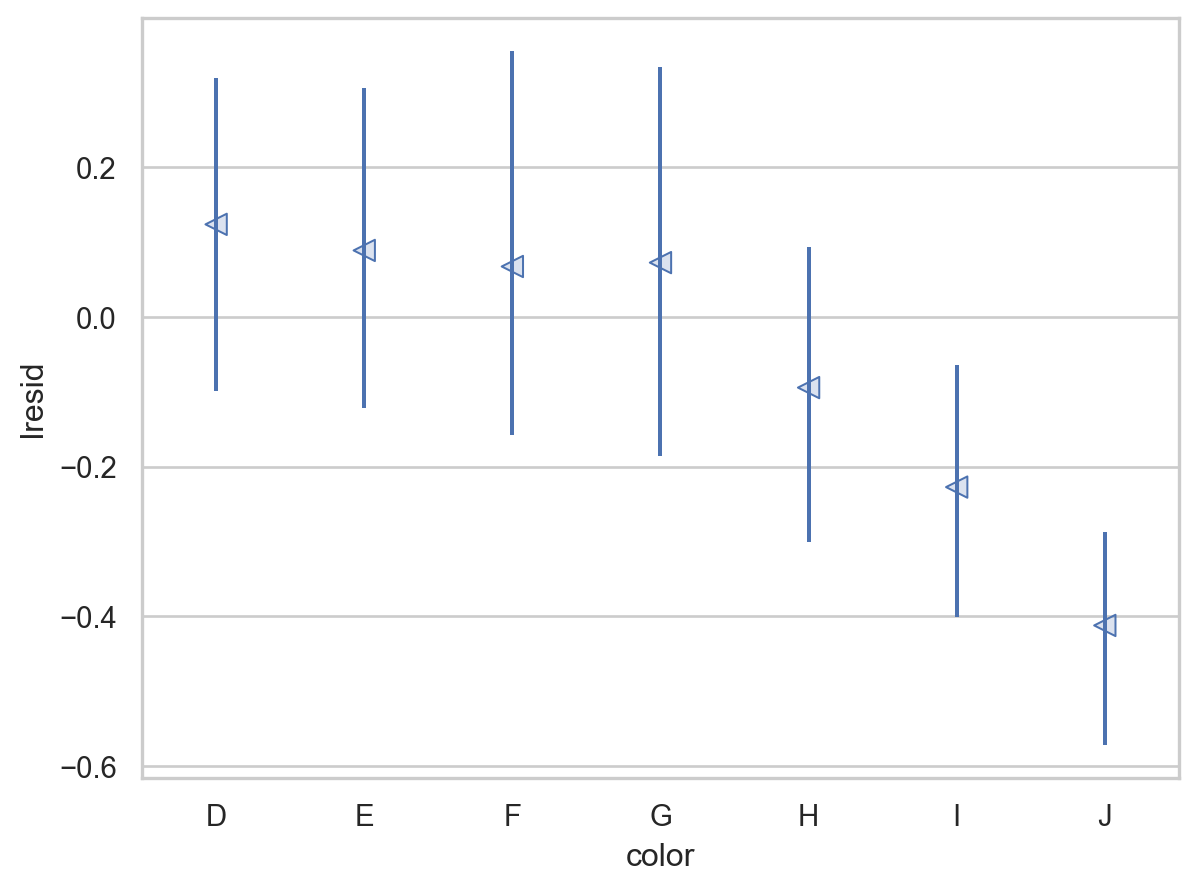

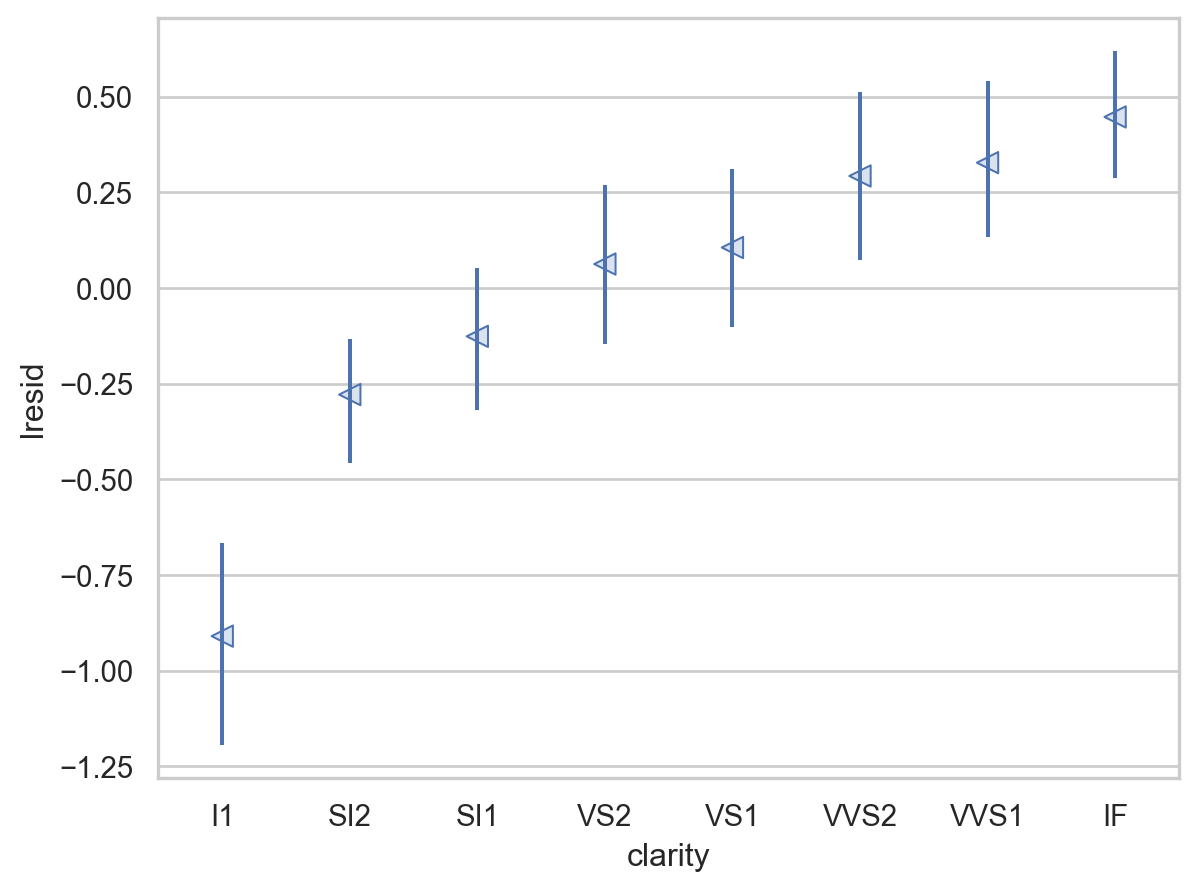

In [433]:
#| layout-ncol: 2
#| echo: false
display(cut)
display(color)
display(clarity)

In [434]:
mod1 = ols("lprice ~ lcarat + cut", data=diamonds2).fit()
mod2 = ols("lprice ~ lcarat + color", data=diamonds2).fit()
mod3 = ols("lprice ~ lcarat + clarity", data=diamonds2).fit()

# mod.params

In [435]:
#| echo: false
pd.options.display.max_rows = 0

In [436]:
#| layout-ncol: 2
#| echo: false
display(mod1.params)
display(mod2.params)
display(mod3.params)

Intercept          11.84
cut[T.Good]         0.23
cut[T.Very Good]    0.34
cut[T.Premium]      0.33
cut[T.Ideal]        0.45
lcarat              1.70
dtype: float64

Intercept    12.37
color[T.E]   -0.04
color[T.F]   -0.05
color[T.G]   -0.08
color[T.H]   -0.27
color[T.I]   -0.41
color[T.J]   -0.61
lcarat        1.73
dtype: float64

Intercept         11.24
clarity[T.SI2]     0.66
clarity[T.SI1]     0.87
clarity[T.VS2]     1.08
clarity[T.VS1]     1.15
clarity[T.VVS2]    1.38
clarity[T.VVS1]    1.45
clarity[T.IF]      1.58
lcarat             1.81
dtype: float64

In [437]:
#| echo: false
pd.options.display.max_rows = 7

다이아몬드의 3가지 퀄리티가 서로 연관되어 있다면?

In [438]:
table1 = diamonds.groupby(["cut", "color"]).size().reset_index(name="n")
table2 = diamonds.groupby(["cut", "clarity"]).size().reset_index(name="n")
table3 = diamonds.groupby(["color", "clarity"]).size().reset_index(name="n")

In [439]:
p1 = so.Plot(table1, x="cut", y="color", pointsize="n", color="n").add(so.Dot()).scale(pointsize=(5, 30))
p2 = so.Plot(table2, x="cut", y="clarity", pointsize="n", color="n").add(so.Dot()).scale(pointsize=(5, 30))
p3 = so.Plot(table3, x="color", y="clarity", pointsize="n", color="n").add(so.Dot()).scale(pointsize=(5, 30))

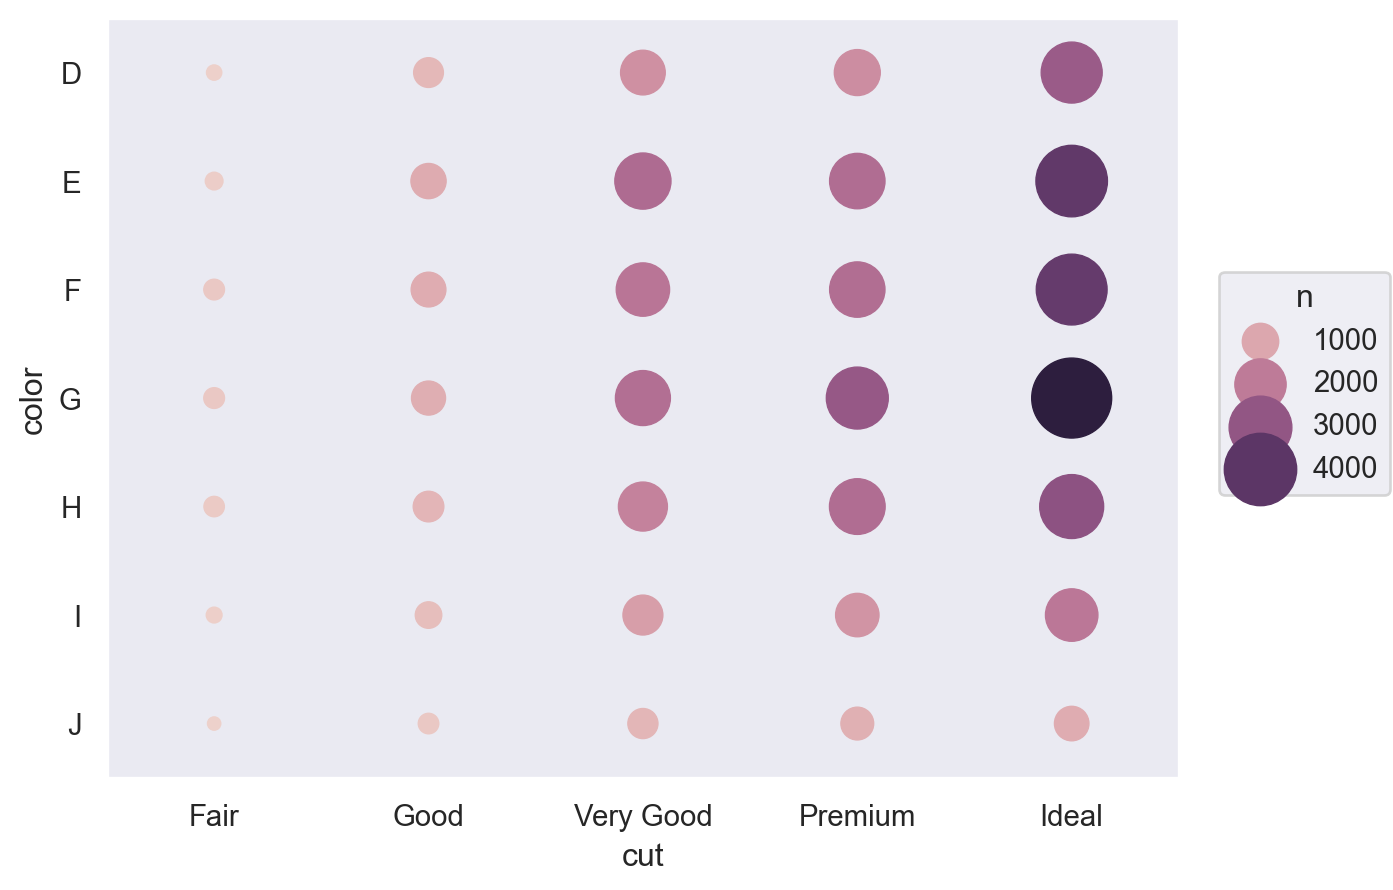

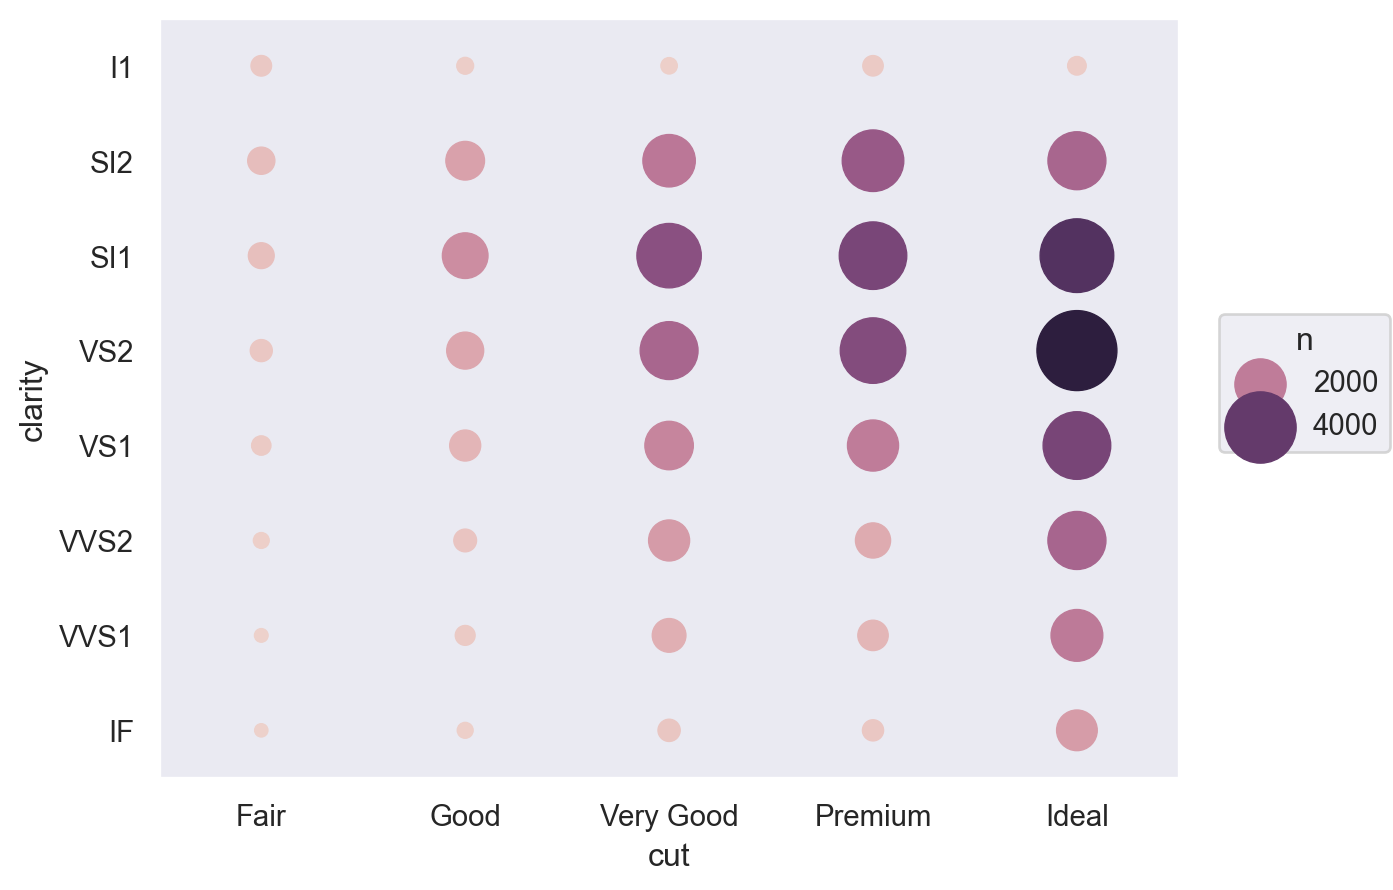

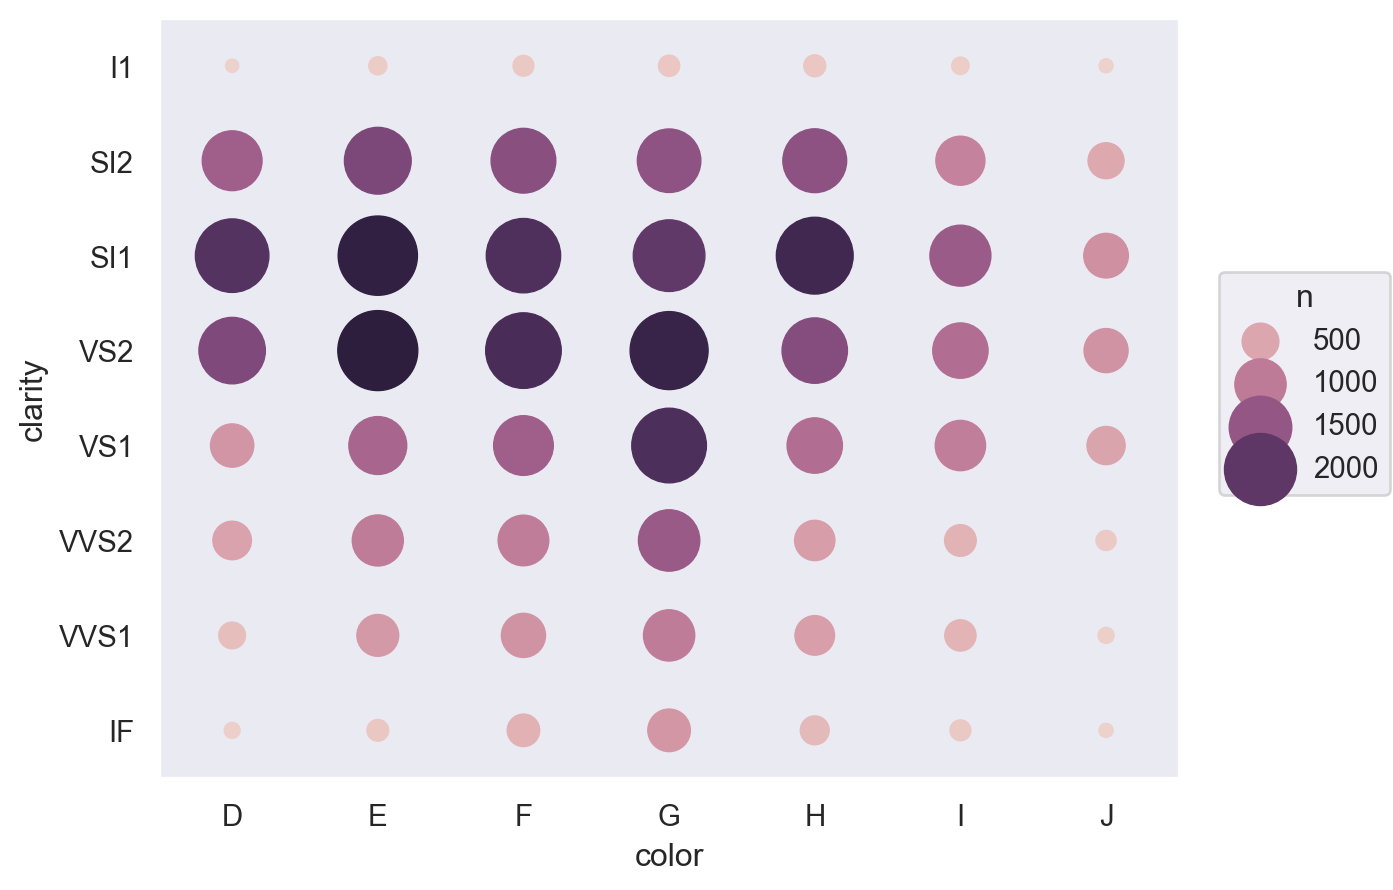

In [440]:
#| layout-ncol: 2
#| echo: false
display(p1)
display(p2)
display(p3)

## A more complicated model

- 다이아몬드의 3가지 퀄리티와 carat이 모두 연관되어 있어, 각각의 고유한 효과를 보기 위해 다음과 같이 모든 예측변수들을 포함하는 모형을 세울 수 있음

In [81]:
mod_full = ols('lprice ~ lcarat + cut + color + clarity', data=diamonds2).fit()

In [82]:
grid = pd.DataFrame({"cut": ["Fair", "Good", "Very Good", "Premium", "Ideal"]})
grid["color"] = diamonds2.color.mode()[0]
grid["clarity"] = diamonds2.clarity.mode()[0]
grid["lcarat"] = diamonds2.lcarat.median()

In [83]:
grid

         cut color clarity  lcarat
0       Fair     G     SI1   -0.51
1       Good     G     SI1   -0.51
2  Very Good     G     SI1   -0.51
3    Premium     G     SI1   -0.51
4      Ideal     G     SI1   -0.51

즉, G 컬러이고, SI1의 투명도와, 로그 캐럿 -0.51 무게인 다이아몬드에 대해서, cut이 좋아질수록 가격이 얼마나 올라가는지를 예측해 본다면,

In [84]:
grid["lpred"] = mod_full.predict(grid)
grid["pred"] = 2**grid.lpred
grid

         cut color clarity  lcarat  lpred    pred
0       Fair     G     SI1   -0.51  10.99 2035.36
1       Good     G     SI1   -0.51  11.10 2202.21
2  Very Good     G     SI1   -0.51  11.16 2285.37
3    Premium     G     SI1   -0.51  11.19 2337.24
4      Ideal     G     SI1   -0.51  11.22 2388.52

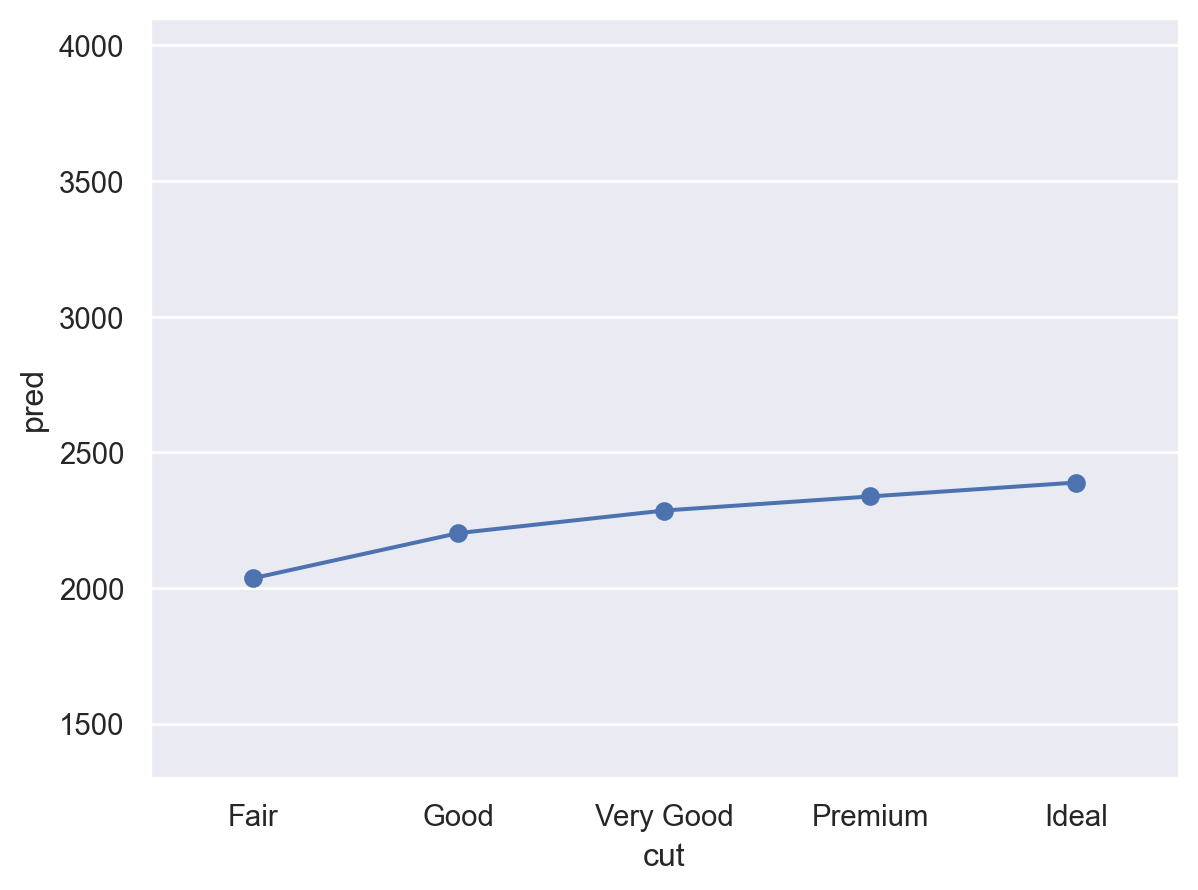

In [85]:
#| layout-ncol: 2
(
    so.Plot(grid, x='cut', y='pred')
    .add(so.Line(marker="o"))
    .limit(y=(1300, 4100))
)

cut 대신 color와 clarity에 대해서도 그려볼 것

In [86]:
#| echo: false
grid = pd.DataFrame({"color": ["D", "E", "F", "G", "H", "I", "J"]})
grid["cut"] = diamonds2.cut.mode()[0]
grid["clarity"] = diamonds2.clarity.mode()[0]
grid["lcarat"] = diamonds2.lcarat.median()
grid["lpred"] = mod_full.predict(grid)
grid["pred"] = 2**grid.lpred

p = (
    so.Plot(grid, x='color', y='pred')
    .add(so.Line(marker="o"))
    .limit(y=(1300, 4100))
)

In [87]:
#| echo: false
grid = pd.DataFrame({"clarity": ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]})
grid["cut"] = diamonds2.cut.mode()[0]
grid["color"] = diamonds2.color.mode()[0]
grid["lcarat"] = diamonds2.lcarat.median()
grid["lpred"] = mod_full.predict(grid)
grid["pred"] = 2**grid.lpred

q = (
    so.Plot(grid, x='clarity', y='pred')
    .add(so.Line(marker="o"))
    .limit(y=(1300, 4100))
)

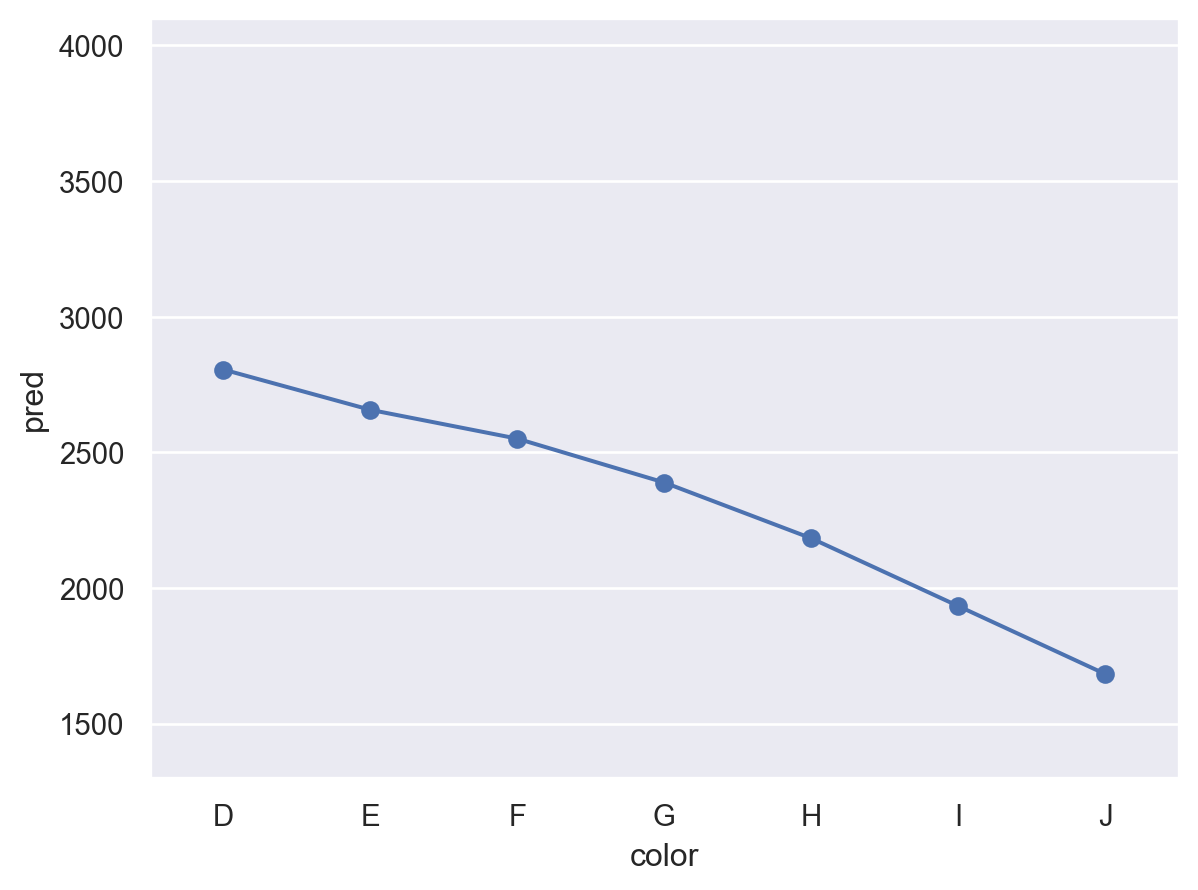

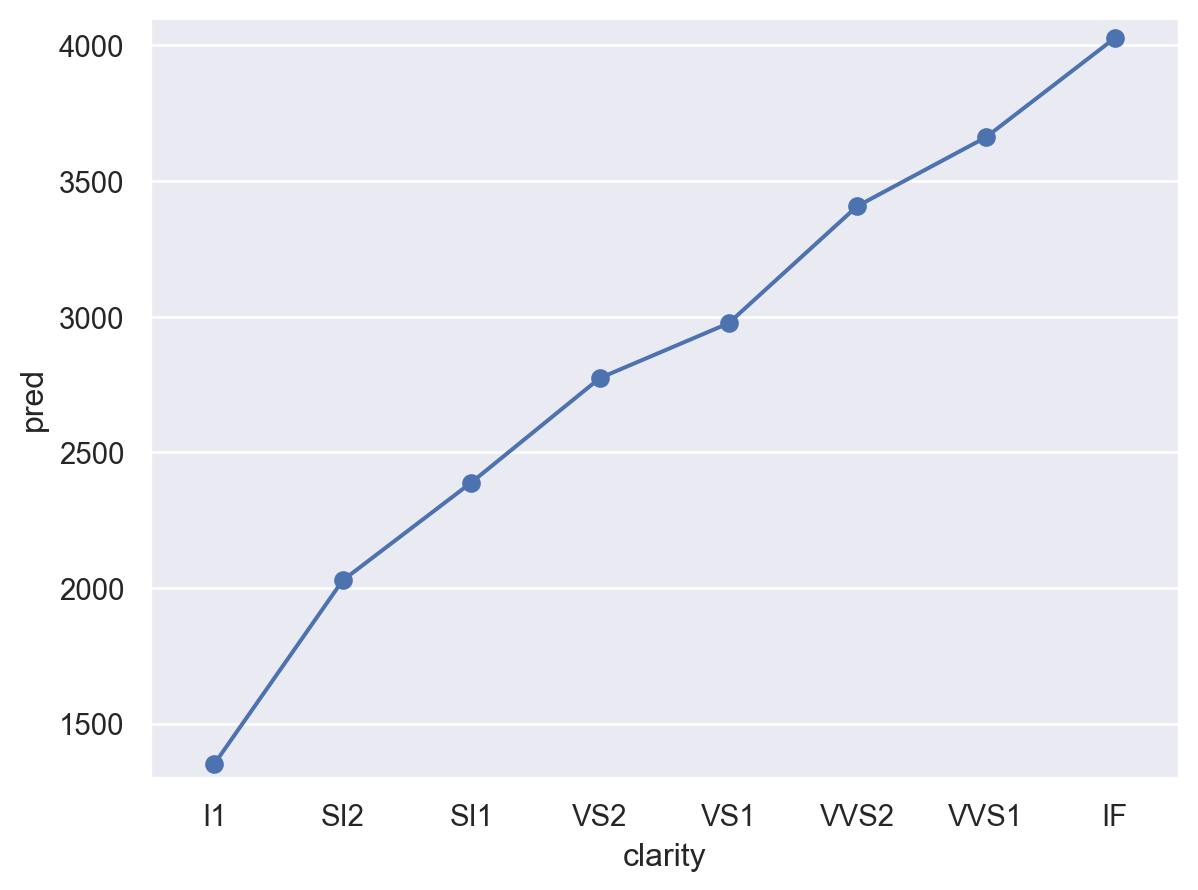

In [88]:
#| layout-ncol: 2
#| echo: false
display(p)
display(q)

In [89]:
#| echo: false
pd.options.display.max_rows = 0

In [90]:
2**mod_full.params[-8:-1]

clarity[T.SI2]    1.50
clarity[T.SI1]    1.77
clarity[T.VS2]    2.06
clarity[T.VS1]    2.20
clarity[T.VVS2]   2.52
clarity[T.VVS1]   2.71
clarity[T.IF]     2.98
dtype: float64

Residuals 분석

In [91]:
diamonds2["lresid_full"] = mod_full.resid

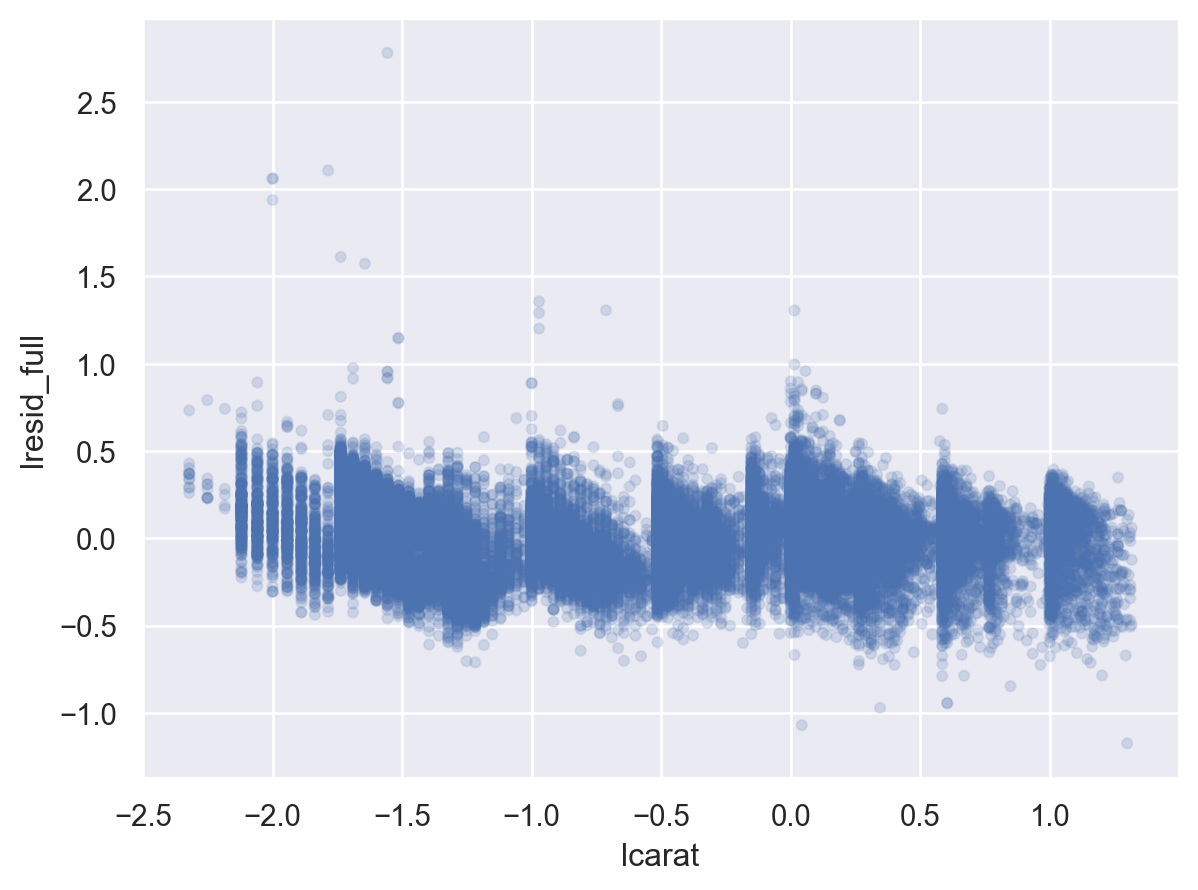

In [92]:
(
    so.Plot(diamonds2, x='lcarat', y='lresid_full')
    .add(so.Dots(alpha=.1))
)

In [93]:
#| echo: false
pd.options.display.max_rows = 7

이상치들만 자세히 들여다보면,

In [94]:
from numpy import abs

diamonds2.query("abs(lresid_full) > 1").assign(
    pred_full=lambda x: 2 ** mod_full.predict(x[["lcarat", "cut", "color", "clarity"]]),
    resid_full=lambda x: x.price - x.pred_full,
).sort_values("resid_full")

       carat      cut color clarity  depth  table  price    x    y    z  \
22440   2.46  Premium     E     SI2  59.70  59.00  10470 8.82 8.76 5.25   
41918   1.03     Fair     E      I1  78.20  54.00   1262 5.72 5.59 4.42   
38153   0.25     Fair     F     SI2  54.40  64.00   1013 4.30 4.23 2.32   
...      ...      ...   ...     ...    ...    ...    ...  ...  ...  ...   
5325    0.61     Good     F     SI2  62.50  65.00   3807 5.36 5.29 3.33   
8203    0.51     Fair     F    VVS2  60.70  66.00   4368 5.21 5.11 3.13   
21935   1.01     Fair     D     SI2  64.60  58.00  10011 6.25 6.20 4.02   

       lprice  lcarat  lresid_full  pred_full  resid_full  
22440   13.35    1.30        -1.17   23630.26   -13160.26  
41918   10.30    0.04        -1.07    2650.65    -1388.65  
38153    9.98   -2.00         1.94     264.51      748.49  
...       ...     ...          ...        ...         ...  
5325    11.89   -0.71         1.31    1539.74     2267.26  
8203    12.09   -0.97         1.36    1

좀 더 체계적으로 다음과 같이 **모형의 복잡성**이 올라감에 따라 예측의 정확성이 어떻게 변하는지 알아보면

In [72]:
diamonds2 = diamonds.query("carat < 2.5").assign(
    lprice=lambda x: np.log2(x.price), 
    lcarat=lambda x: np.log2(x.carat)
)

# nested models
diamonds2_mod1 = ols("lprice ~ lcarat", data=diamonds2).fit()
diamonds2_mod2 = ols("lprice ~ lcarat + clarity", data=diamonds2).fit()
diamonds2_mod3 = ols("lprice ~ lcarat + cut + color + clarity", data=diamonds2).fit()

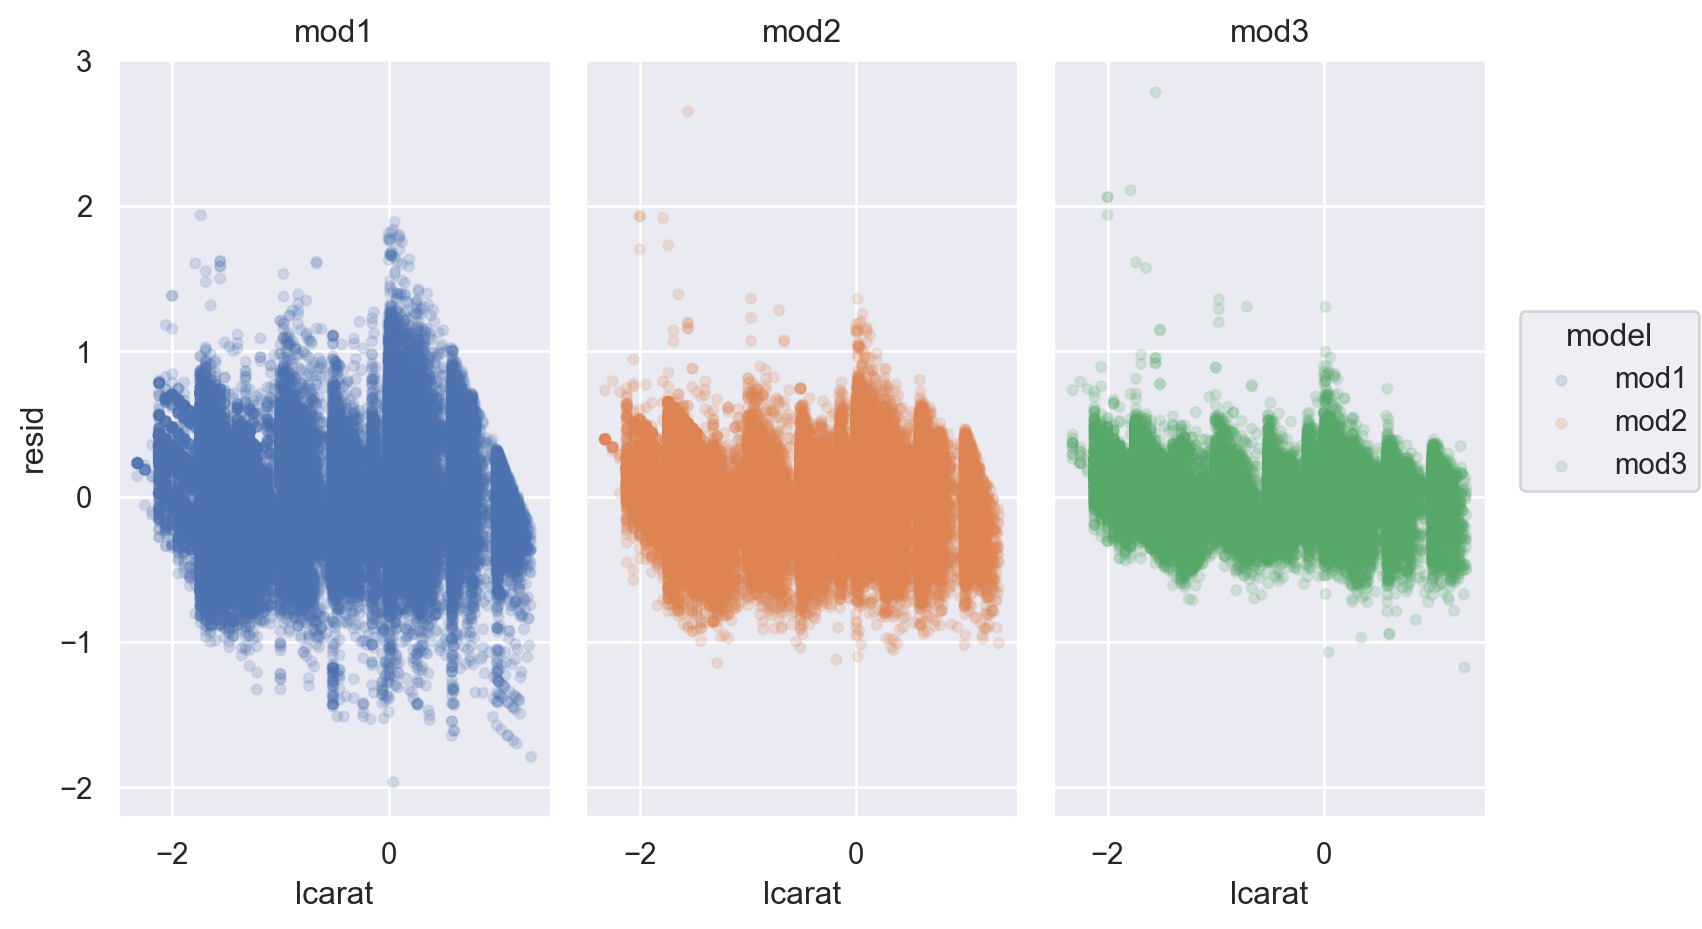

In [106]:
#| code-fold: true
#| code-summary: code

diamonds2_mods = diamonds2.assign(
    mod1=diamonds2_mod1.resid,
    mod2=diamonds2_mod2.resid,
    mod3=diamonds2_mod3.resid,
)

diamonds2_mods = diamonds2_mods.melt(
    id_vars=["lcarat", "lprice"],
    value_vars=["mod1", "mod2", "mod3"],
    var_name="model",
    value_name="resid",
)

(
    so.Plot(diamonds2_mods, x='lcarat', y='resid', color='model')
    .add(so.Dots(alpha=.1))
    .facet("model")
    .layout(size=(8, 5))
)

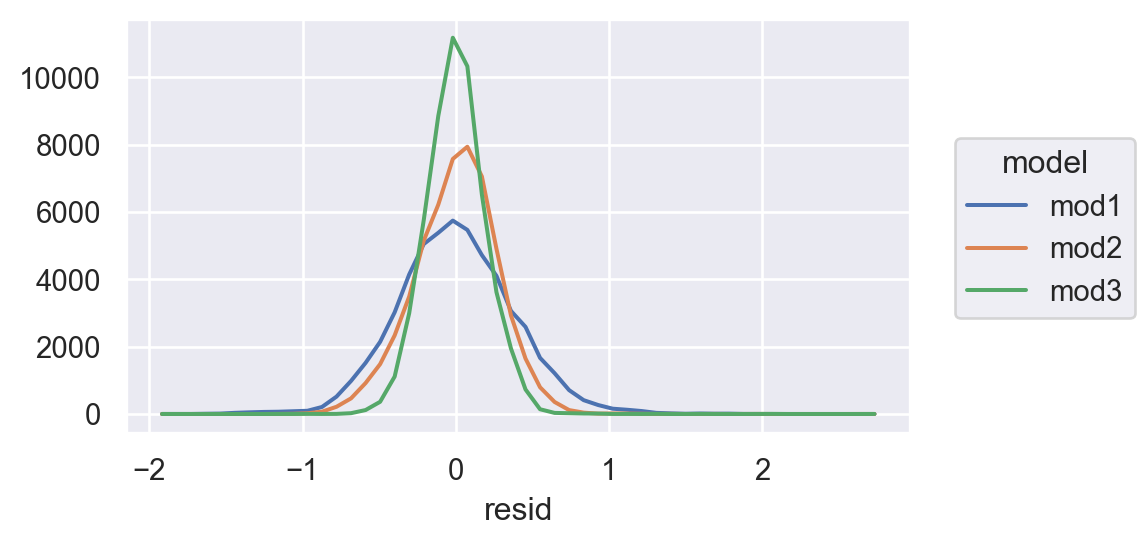

In [105]:
#| code-fold: true
#| code-summary: code
(
    so.Plot(diamonds2_mods, x='resid', color='model')
    .add(so.Line(), so.Hist(bins=50))
    .layout(size=(5, 3))
)

In [115]:
#| code-fold: true
#| code-summary: code
from statsmodels.tools.eval_measures import rmse, meanabs

mods = [diamonds2_mod1, diamonds2_mod2, diamonds2_mod3]
y = diamonds2.price
print("The prediction accuracy of the models (original unit except R-squared):\n")

for mod in mods:
    y_hat = 2**mod.fittedvalues
    R2 = mod.rsquared

    print(
        f"R-squared: {R2:.2f}, RMSE: {rmse(y, y_hat):.2f}, "
        f"MAE:{meanabs(y, y_hat):.2f}"
    )

The prediction accuracy of the models (original unit except R-squared):

R-squared: 0.93, RMSE: 1507.04, MAE:817.34
R-squared: 0.97, RMSE: 1164.81, MAE:623.65
R-squared: 0.98, RMSE: 732.70, MAE:390.61


::: {.callout-note}

#### Model evaluation: R-squared, RMSE, MAE

**The prediction accuracy** of the models can be evaluated by the following metrics:  
(**The strength of association**)

변량의 비율로 해석하고 싶다면,

$\displaystyle\frac{V(predictions)}{V(Y)} + \frac{V(residuals)}{V(Y)} = 1,$ &nbsp; (OLS estimate)

즉, "모형에 의해 설명되는 $Y$ 변량의 **비율**" + "모형에 의해 설명되지 않는 $Y$ 변량의 **비율**" = 1  
첫 항을 $R^2$ 라고 하고, **결정계수** 혹은 R squared라고 부름  
따라서, $1-R^2$ 는 설명되지 않는 변량의 비율이라고 할 수 있음.  
$또한, R$은 multiple correlation coefficient라고 부르는데, 이는 $Y$와 예측값 $\hat Y$의 상관계수(Pearson's correlation coefficient)를 의미함.

비율이 아닌 $Y$의 단위와 동일한 단위로 해석하고 싶다면,

- Root-mean-squared deviation/error: $RMSE = \displaystyle\sqrt{\frac{1}{n} \sum_{i=1}^{n}{(y_i -\hat y_i)^2}}$  

- Mean absolute error: $MAE = \displaystyle\frac{1}{n} \sum_{i=1}^{n}{|~y_i -\hat y_i~|}$ : 이상치에 덜 민감함

:::

## Interactions

무게(carat)과 투명도(clarity)가 상호작용하여 가격에 영향을 준다는 가정하에,
즉, 투명도의 레벨에 따라 무게와 가격의 관계가 바뀔 수 있다는 가정

In [77]:
diamonds2_mod2 = ols("lprice ~ lcarat + clarity", data=diamonds2).fit()
diamonds2_mod2_interact = ols("lprice ~ lcarat * clarity", data=diamonds2).fit()

Prediction 비교

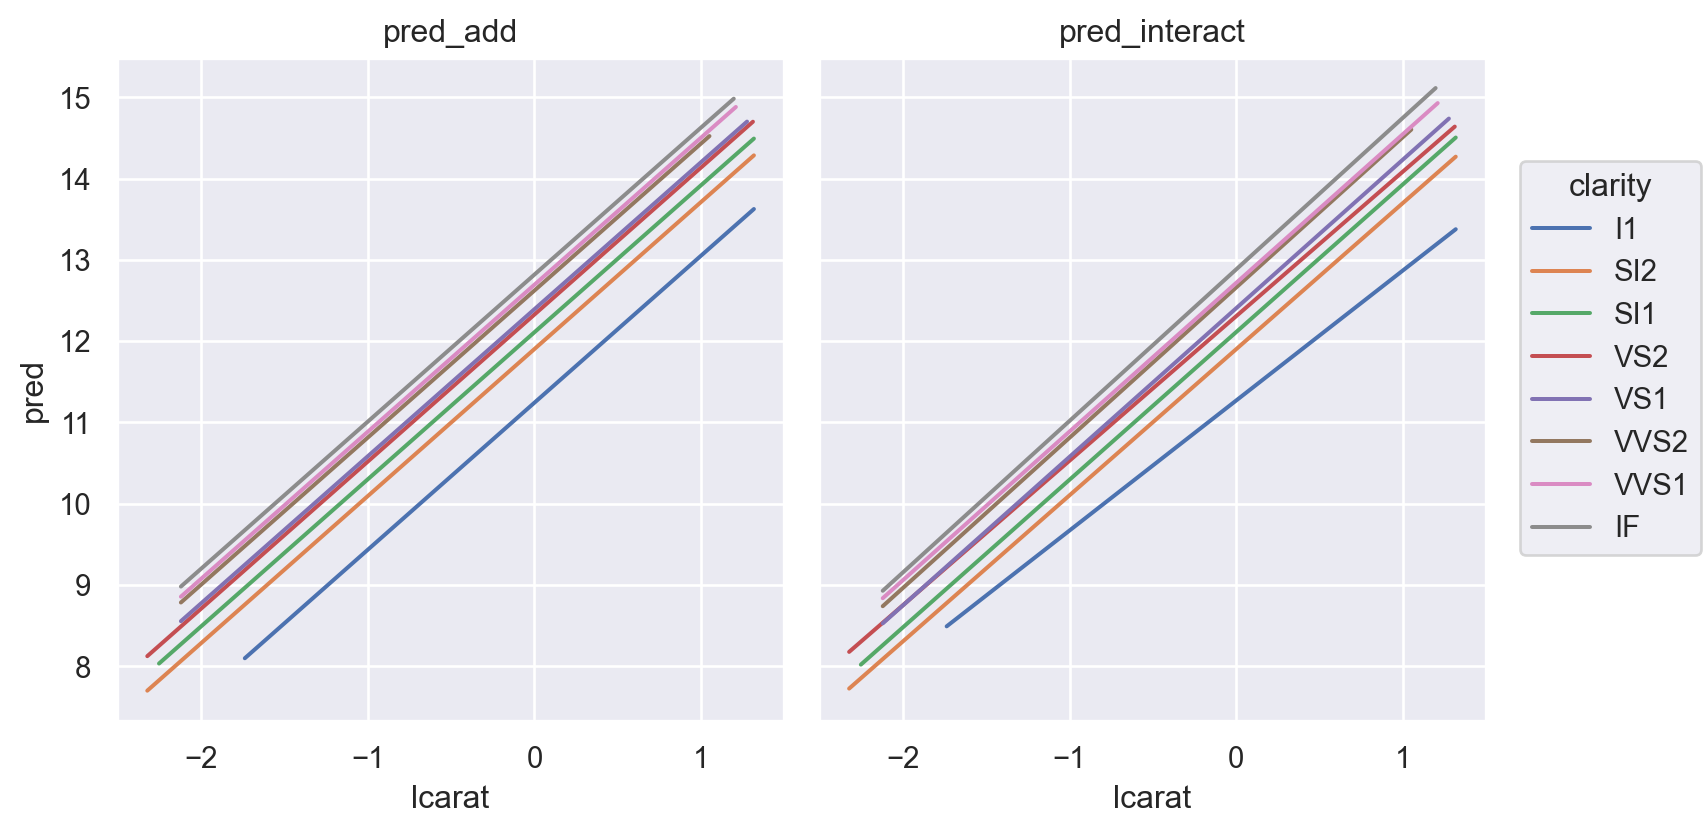

In [78]:
#| code-fold: true
#| code-summary: code

diamonds2_mods = diamonds2.assign(
    pred_add=diamonds2_mod2.fittedvalues,
    pred_interact=diamonds2_mod2_interact.fittedvalues,
)

diamonds2_mods = diamonds2_mods.melt(
    id_vars=["lcarat", "lprice", "clarity"],
    value_vars=["pred_add", "pred_interact"],
    var_name="model",
    value_name="pred",
)

(
    so.Plot(diamonds2_mods, x='lcarat', y='pred', color='clarity')
    .add(so.Line())
    .scale(color=so.Nominal(order=diamonds2.clarity.cat.categories.tolist()))
    .facet("model")
    .layout(size=(8, 4.5))
)

Residuals 비교

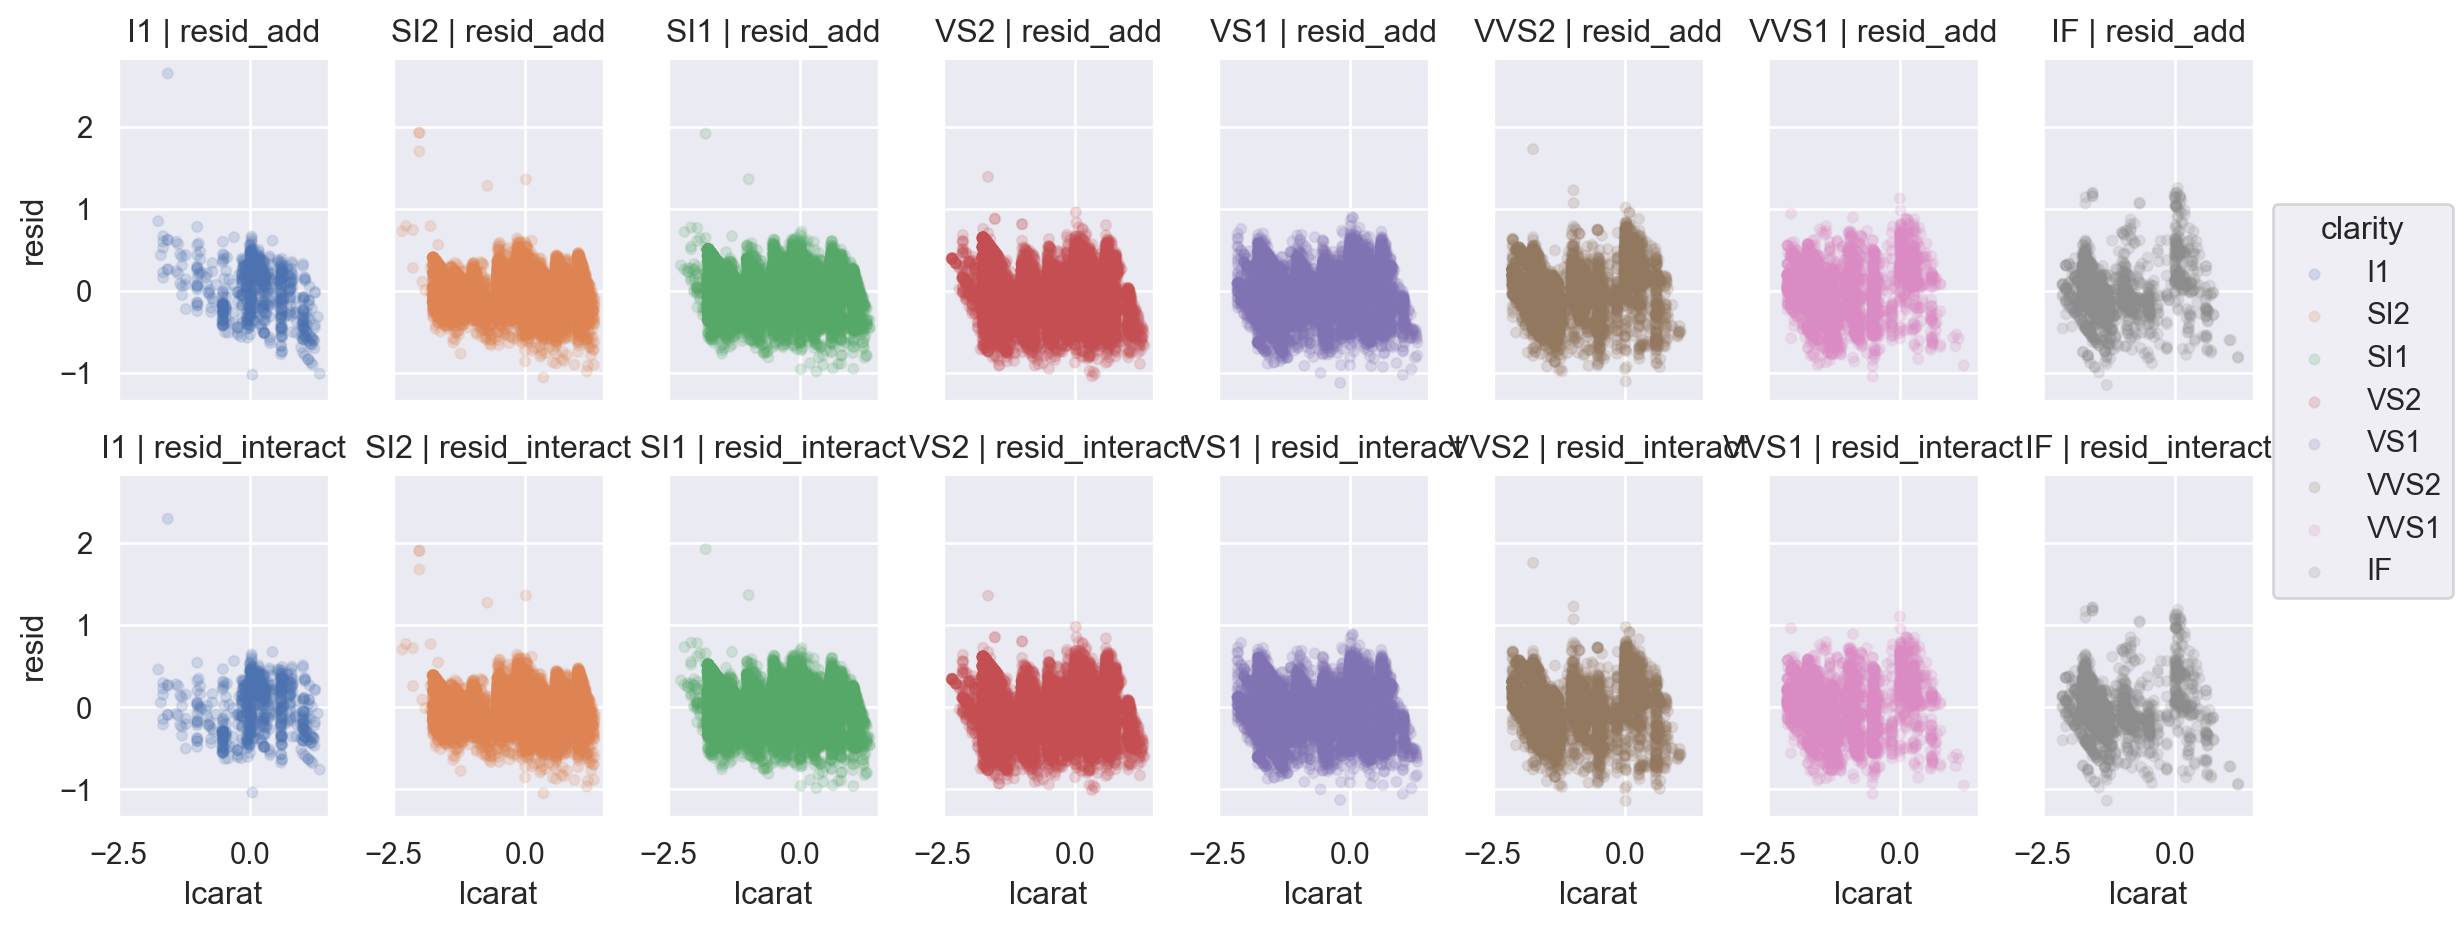

In [79]:
#| code-fold: true
#| code-summary: code

diamonds2_mods = diamonds2.assign(
    resid_add=diamonds_mod2.resid,
    resid_interact=diamonds_mod2_interact.resid,
)

diamonds2_mods = diamonds2_mods.melt(
    id_vars=["lcarat", "lprice", "clarity"],
    value_vars=["resid_add", "resid_interact"],
    var_name="model",
    value_name="resid",
)

(
    so.Plot(diamonds2_mods, x='lcarat', y='resid', color='clarity')
    .add(so.Dots(alpha=.1))
    .layout(size=(12, 5))
    .facet("clarity", "model")
)


# 두 가지 관점

## 모델 파라미터의 해석
변수와 변수간의 관계성에 초점

변수들을 “**동시”**에 고려해서 봄으로써 각 변수들의 “**고유한 impact”의 방향과 크기**를 해석하고자 함

ex. `ols(lprice ~ lcarat + color + cut + clarity, data = diamonds2)`

다이아몬드 투명도(clarity)의 레벨이 하나씩 올라감에 따라 가격형성에 어떻게 혹은 얼마나 영향을 주는가?

- 표현에 주의할 것: 인과관계가 있는 듯한 표현... `lprice ~ clarity`의 관계는?

- 변수들을 개별적으로 보았을 때의 impact는 다른 변수들을 함께 고려하면 바뀌는 것이 일반적임 (서로 독립이 아니라면)
    - ex. 다이아몬드 투명도가 가격과 맺는 관계는 다른 변수를 고려하면 바뀜
- Bias의 생성: 편견? 스키마?

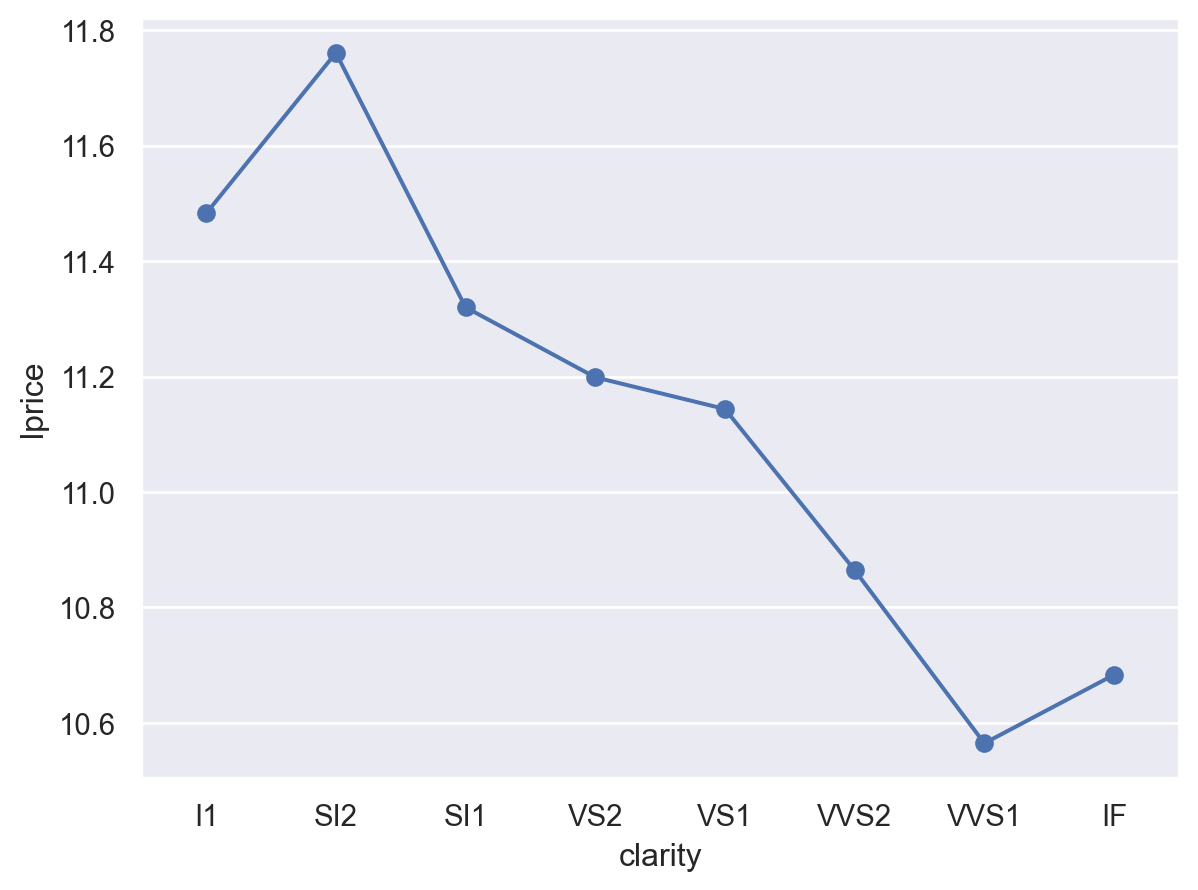

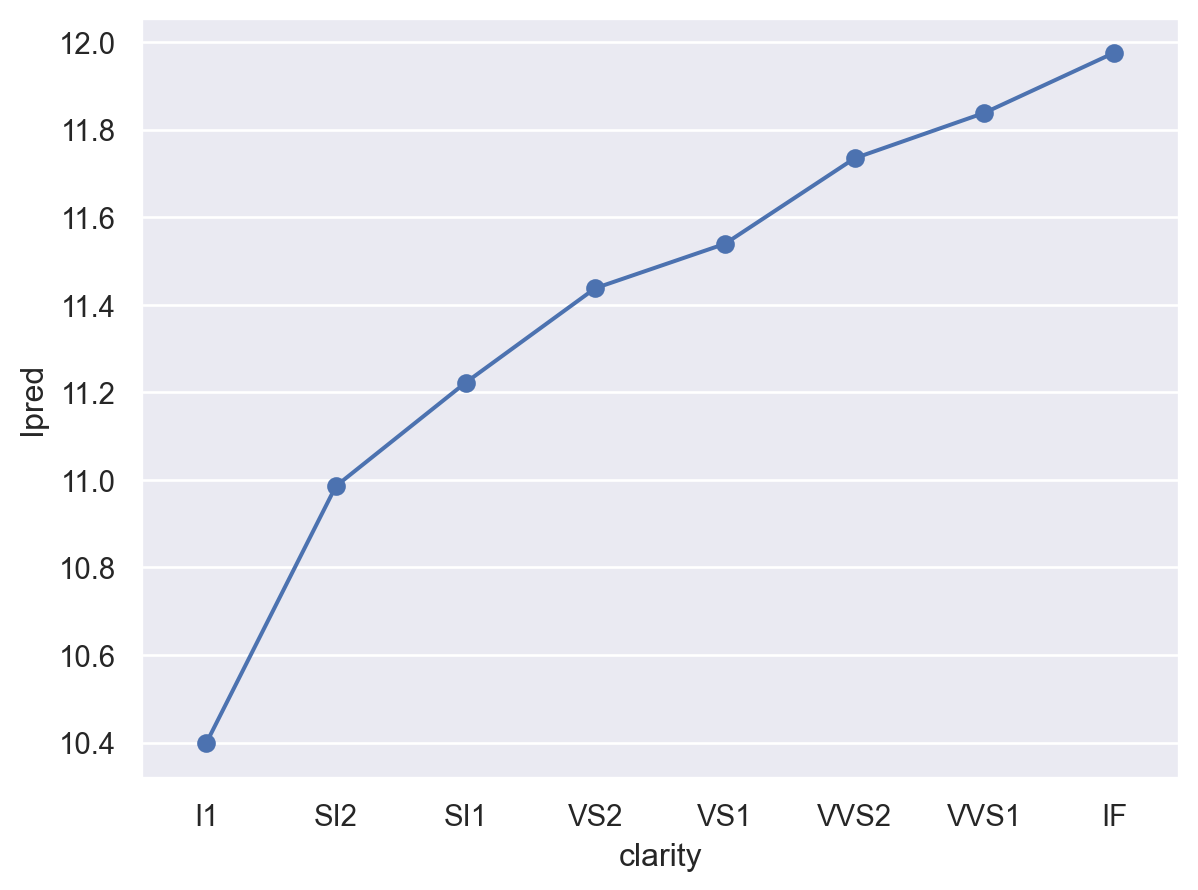

clarity[T.SI2]    0.59
clarity[T.SI1]    0.82
clarity[T.VS2]    1.04
                  ... 
clarity[T.VVS1]   1.44
clarity[T.IF]     1.58
lcarat            1.89
Length: 8, dtype: float64

In [95]:
#| layout-ncol: 2
#| echo: false
p = (
    so.Plot(diamonds2, x="clarity", y="lprice")
    .add(so.Line(marker="o"), so.Agg())
)
q = (
    so.Plot(grid, x='clarity', y='lpred')
    .add(so.Line(marker="o"))
)
display(p)
display(q)
display(mod_full.params[-8:])

또한, 변수간의 **상호작용**을 고려하여, 각 변수들의 “**고유한 impact”의 방향과 크기**에 대해 정교한 분석이 가능

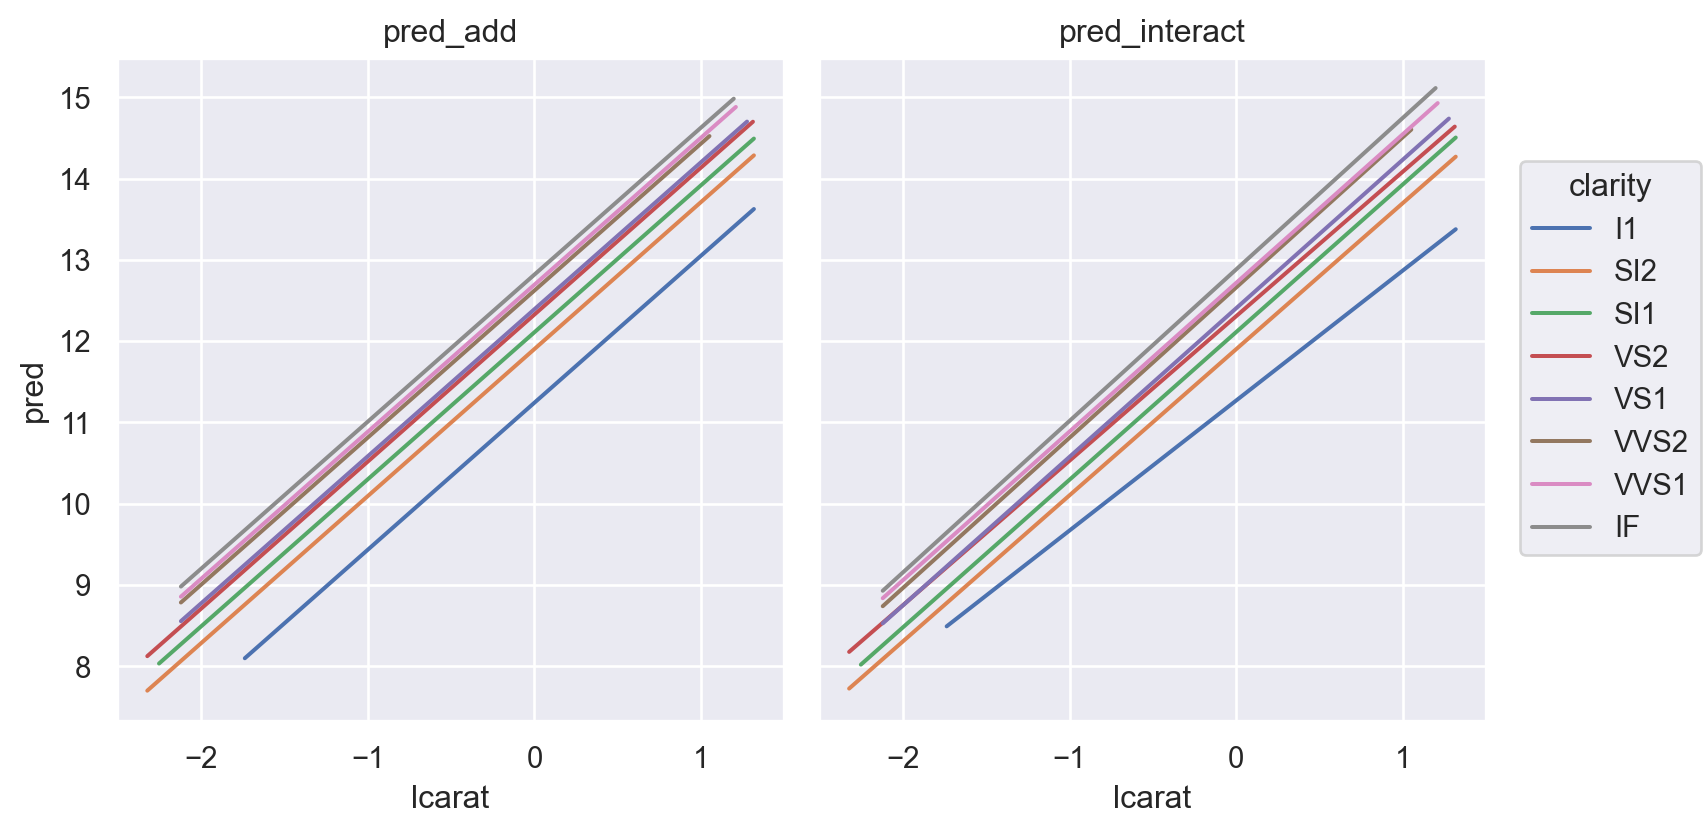

In [71]:
#| echo: false
diamonds2_mods = diamonds2.assign(
    pred_add=diamonds_mod2.fittedvalues,
    pred_interact=diamonds_mod2_interact.fittedvalues,
)

diamonds2_mods = diamonds2_mods.melt(
    id_vars=["lcarat", "lprice", "clarity"],
    value_vars=["pred_add", "pred_interact"],
    var_name="model",
    value_name="pred",
)

(
    so.Plot(diamonds2_mods, x='lcarat', y='pred', color='clarity')
    .add(so.Line())
    .scale(color=so.Nominal(order=diamonds2.clarity.cat.categories.tolist()))
    .facet("model")
    .layout(size=(8, 4.5))
)

In [96]:
#| echo: false
pd.options.display.max_rows = 0
diamonds2_mod2_interact.params[-8:]

lcarat                   1.60
lcarat:clarity[T.SI2]    0.20
lcarat:clarity[T.SI1]    0.22
lcarat:clarity[T.VS2]    0.18
lcarat:clarity[T.VS1]    0.23
lcarat:clarity[T.VVS2]   0.25
lcarat:clarity[T.VVS1]   0.23
lcarat:clarity[T.IF]     0.27
dtype: float64

## (fitted) 모델의 예측 정확성과 특성
Residuals의 분석

변수의 개수가 증가하면, 즉 모델이 복잡할 수록 샘플에 대한 예측력은 높아짐.

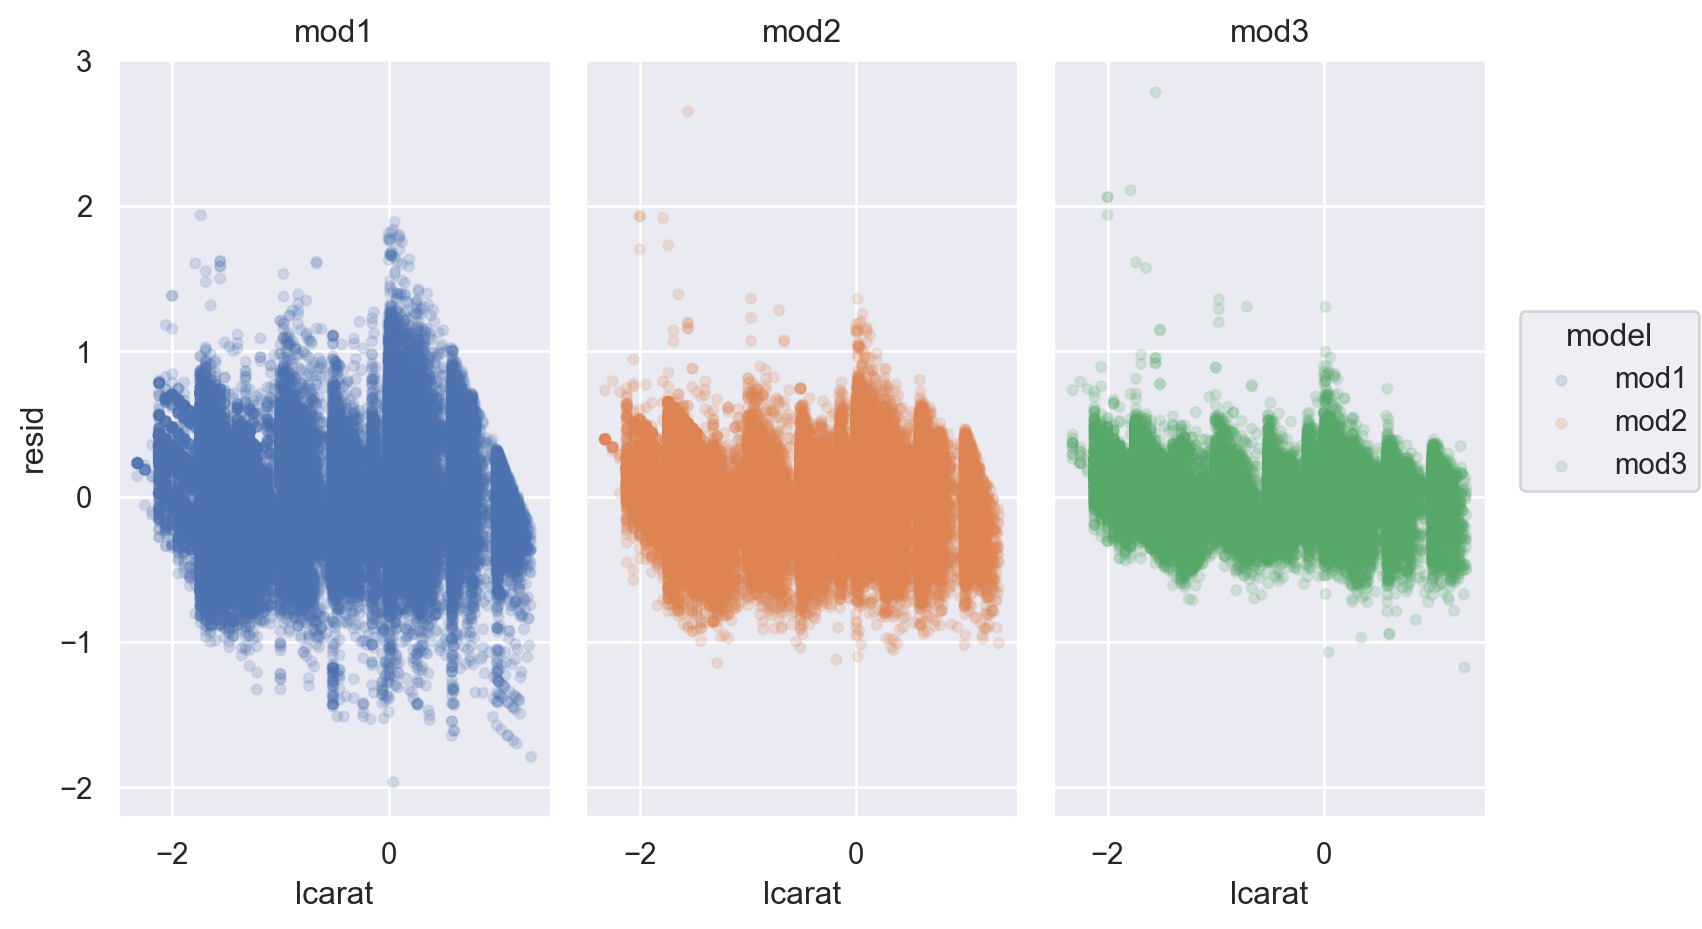

In [101]:
#| echo: false
diamonds2_mods = diamonds2.assign(
    mod1=diamonds2_mod1.resid,
    mod2=diamonds2_mod2.resid,
    mod3=diamonds2_mod3.resid,
)

diamonds2_mods = diamonds2_mods.melt(
    id_vars=["lcarat", "lprice"],
    value_vars=["mod1", "mod2", "mod3"],
    var_name="model",
    value_name="resid",
)
(
    so.Plot(diamonds2_mods, x='lcarat', y='resid', color='model')
    .add(so.Dots(alpha=.1))
    .facet("model")
    .layout(size=(8, 5))
)


- variance의 증가: Bias-Variance Tradeoff  
  [Source](https://www.vexpower.com/brief/biasvariance-tradeoff)

![](images/bias.png){width=800}  


- 반면, 변수들 간의 복잡한 correlation들이 모델의 해석에 오류를 가져올 수 있음.

---

# Exercises

샌프란시스코행 항공편의 도착은 왜 지연되었는가? `nycflights13`

- 출처: [Modern Data Science with R (2e)](https://mdsr-book.github.io/mdsr2e/ch-foundations.html#sec:gooddesign)
- 저자는 왜 아래와 같은 모형을 세웠을까?
- 다음은 좋은 모형인가?

In [128]:
# import the data
flights = sm.datasets.get_rdataset('flights', 'nycflights13').data

# convert the date column to a datetime object
flights["time_hour"] = pd.to_datetime(flights["time_hour"])

# add a column for the day of the week
flights["dow"] = (
    flights["time_hour"]
    .dt.day_name()
    .str[:3]
    .astype("category")
    .cat.set_categories(["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
)

# add a column for the season
flights["season"] = np.where(pd.eval('flights["month"] in [6, 7]'), "summer", "other month")

In [146]:
# filter out the flights to SFO
sfo = flights[flights.arr_delay.notna()].query('dest == "SFO" & arr_delay < 500').copy()

In [147]:
mod = ols("arr_delay ~ hour + origin + carrier + season + dow", data=sfo).fit()